In [34]:
#importing all the required libraries

import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
import pickle

# Undistorting the images
Read all the input images for calibrating the camera images.

In [35]:
def read_calib_images():
    input_images = glob.glob('camera_cal/*.jpg')
    calib_imgs = []

    for file in input_images:
        img = mpimg.imread(file)
        calib_imgs.append(img)
        
    return calib_imgs

def read_test_images():
    input_images = glob.glob('test_images/*.jpg')
    test_imgs = []

    for file in input_images:
        img = mpimg.imread(file)
        test_imgs.append(img)
        
    return test_imgs


Function to find corners in chess board, and seperate the images in which the corners cannot be detected

In [36]:
def find_corners(imgs, x, y):
    points_3D = [] 
    points_2D = [] 
    
    corners_not_detected = [] 
    corners_detected = [] 
    
    obj_3D = np.zeros((x * y, 3), np.float32)
    obj_3D[:,:2] = np.mgrid[0:x, 0:y].T.reshape(-1, 2)
    
    for img in imgs:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray_img, (x, y), None)
        
        if ret == True:
            points_3D.append(obj_3D)
            points_2D.append(corners)
            corners_detected.append(img)
        else:
            corners_not_detected.append(img)
            
    return points_3D, points_2D, corners_detected, corners_not_detected

Testing the functionality of Corners detected and not detected in the list of input images

Number of images in which corners were detected =  17
Number of images in which corners were not detected =  3

images of corners detected


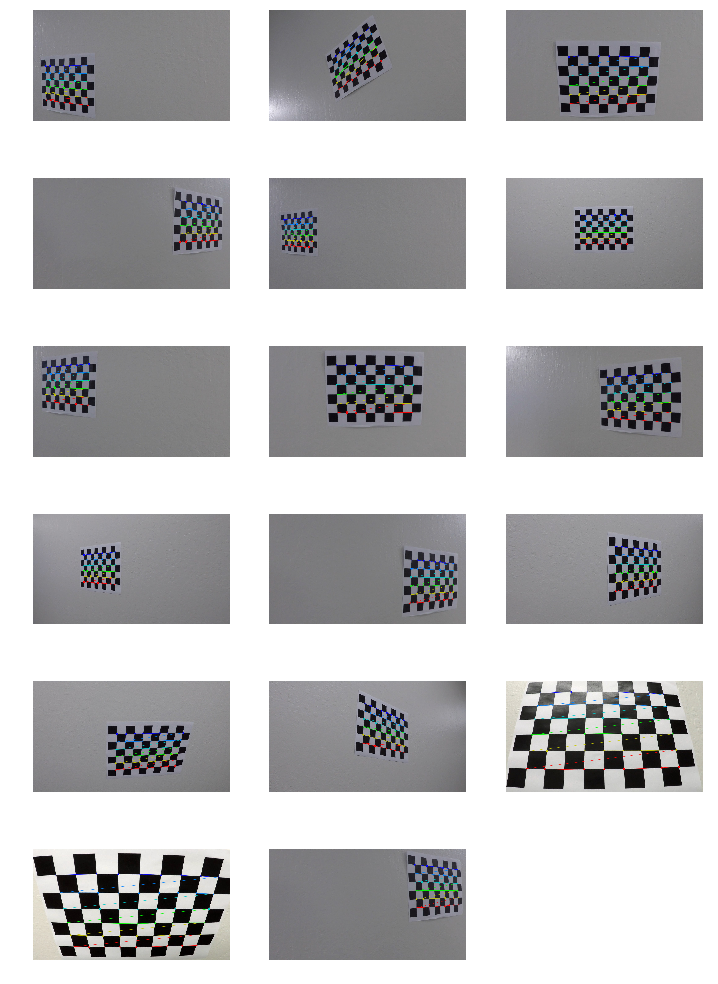


images of corners not detected


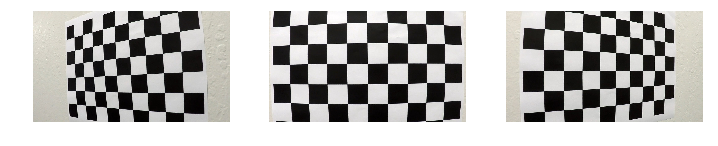

In [37]:
#Number of corners to be found
no_x = 9
no_y = 6

calib_imgs = read_calib_images()
points_3D, points_2D, corners_detected, corners_not_detected = find_corners(calib_imgs, no_x, no_y)

print("Number of images in which corners were detected = ", len(corners_detected))
print("Number of images in which corners were not detected = ", len(corners_not_detected))

# view the images
print("")
print("images of corners detected")
plt.figure(figsize=(12, 18))
for idx, img in enumerate(corners_detected):
    cv2.drawChessboardCorners(img, (no_x, no_y), points_2D[idx], True)
    plt.subplot(6, 3, idx+1)
    plt.imshow(img)
    plt.axis('off')    
plt.show()

print("")
print("images of corners not detected")
plt.figure(figsize=(12, 3))
for idx, img in enumerate(corners_not_detected):
    plt.subplot(1, 3, idx+1)
    plt.imshow(img)
    plt.axis('off')    
plt.show()



Since the number of x and y corners to be detected is more than the number of corners that could be observed in the previous 3 images, it is classified as not detected

Function to undistort an image

In [38]:
def get_calibration_value(img, points_3D, points_2D):
    
    img_shape = (img.shape[0], img.shape[1])
    
    #calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(points_3D, points_2D, img_shape, None, None)
    return mtx, dist

def undistort_img(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

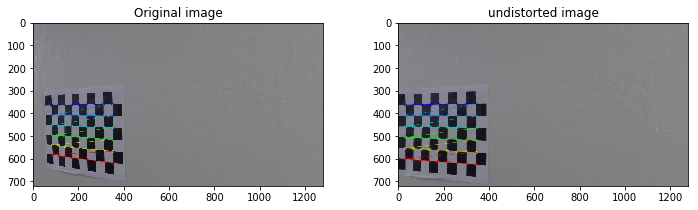

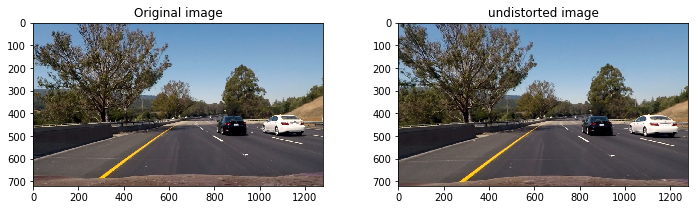

In [39]:
mtx, dist = get_calibration_value(corners_detected[0], points_3D, points_2D)

calibration_value = {}
calibration_value["mtx"] = mtx
calibration_value["dist"] = dist
pickle.dump( calibration_value, open( "calibration_value.p", "wb" ) )

undist_img = undistort_img(corners_detected[0], mtx, dist)

plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(corners_detected[0])
plt.subplot(1,2,2)
plt.title("undistorted image")
plt.imshow(undist_img)
plt.show()

test_imgs = read_test_images()
test_img = test_imgs[3]
plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(test_img)
plt.subplot(1,2,2)
plt.title("undistorted image")
plt.imshow(undistort_img(test_img, mtx, dist))
plt.show()

# Pipeline for lane detection
Convert the images to binary format

In [40]:
def convert_to_binary(img, sobel_thresh=(25,255), s_thresh=(125, 255), l_thresh=(125,255)):
    
    raw_img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(raw_img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    
    # Sobel x
    sobel_x = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) 
    abs_sobel_x = np.absolute(sobel_x)
    scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    
    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    binary = np.zeros_like(sx_binary)
    binary[((l_binary == 1) & (s_binary == 1) | (sx_binary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    return binary

Testing the binary functionality

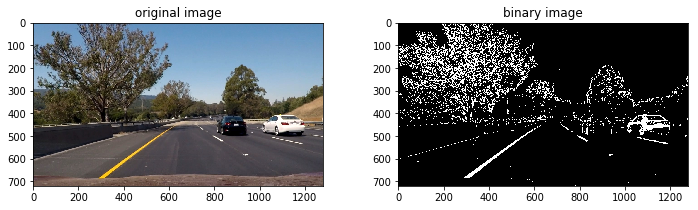

In [41]:

binary = convert_to_binary(test_img)
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(test_img)
plt.subplot(1,2,2)
plt.imshow(binary)
plt.title("binary image")
plt.show()

Warping the images

In [42]:
# depending on the requirement of top view or camera view, warp the image
def img_warp(img, top_view=True):
    
    src = np.float32(
        [[120, 720],
         [580, 450],
         [750, 450],
         [1160, 720]])

    dst = np.float32(
        [[200,720],
         [200,0],
         [1080,0],
         [1080,720]])
    img_shape = (img.shape[1], img.shape[0])
    
    if top_view:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
        
    warped_img = cv2.warpPerspective(img, M, img_shape, flags=cv2.INTER_LINEAR)
    
    return warped_img

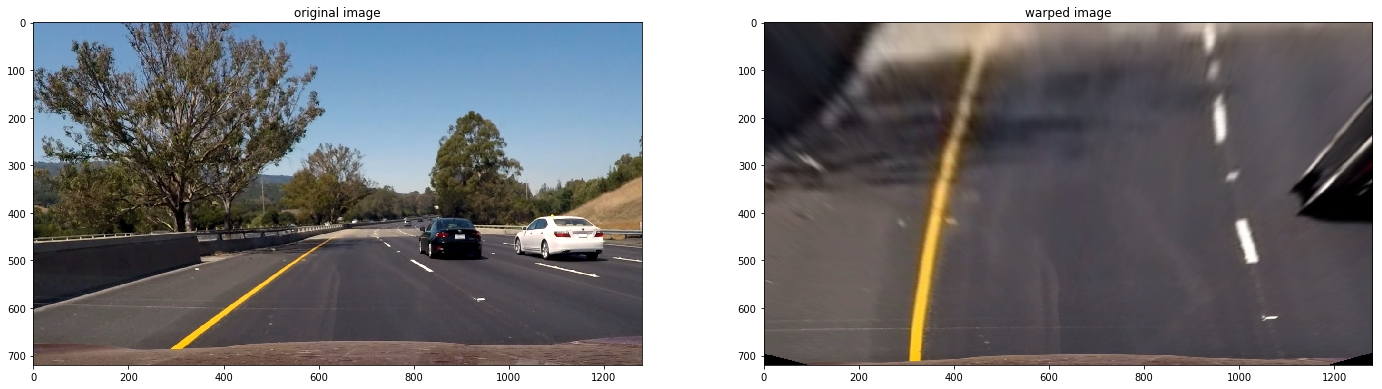

In [43]:

with open('calibration_value.p', mode='rb') as f:
    calibration_value = pickle.load(f)
    mtx = calibration_value["mtx"]
    dist = calibration_value["dist"]

undist_img = undistort_img(test_img, mtx, dist)
warped_img = img_warp(undist_img)
plt.figure(figsize=(24,9))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(test_img)
plt.subplot(1,2,2)
plt.imshow(warped_img)
plt.title("warped image")
plt.show()

In [44]:
def img_msk(img):
    points = np.array([[(0,img.shape[0]),(580, 450), (750, 450), (img.shape[1],img.shape[0])]], dtype=np.int32)
    msk = np.zeros_like(img)
    
    no_of_channels = img.shape[2]
    msk_color = (255, ) * no_of_channels
    
    cv2.fillPoly(msk, points, msk_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, msk)
    return masked_image

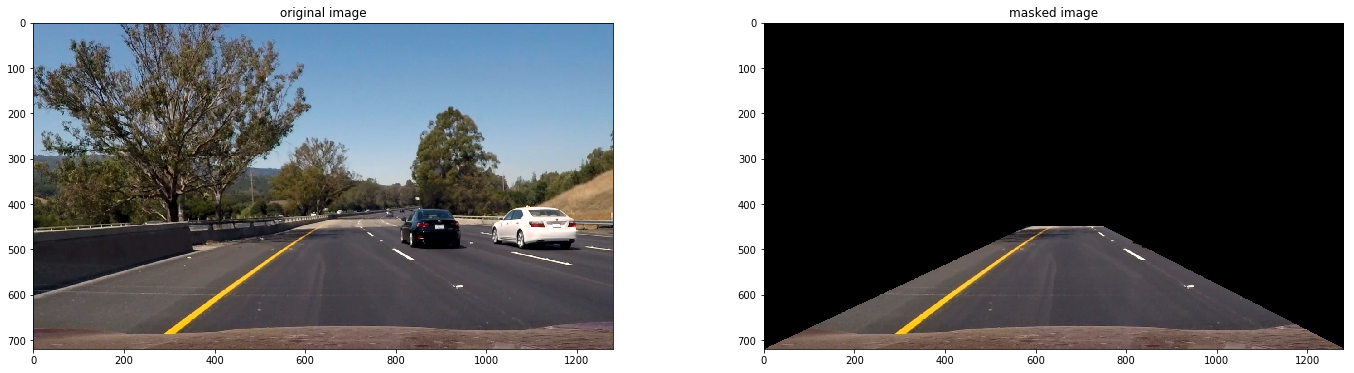

In [45]:
msk_img = img_msk(test_img)

plt.figure(figsize=(24,6))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(test_imgs[3])
plt.subplot(1,2,2)
plt.imshow(msk_img)
plt.title("masked image")
plt.show()

Pipeline functionality

In [46]:
def warp_pipe(img, mtx, dist):
    undist_img = undistort_img(img, mtx, dist)
    bin_img = convert_to_binary(undist_img)
    msked_img = img_msk(bin_img)
    warp_img = img_warp(msked_img)
    
    return warp_img

Testing the warp pipeline

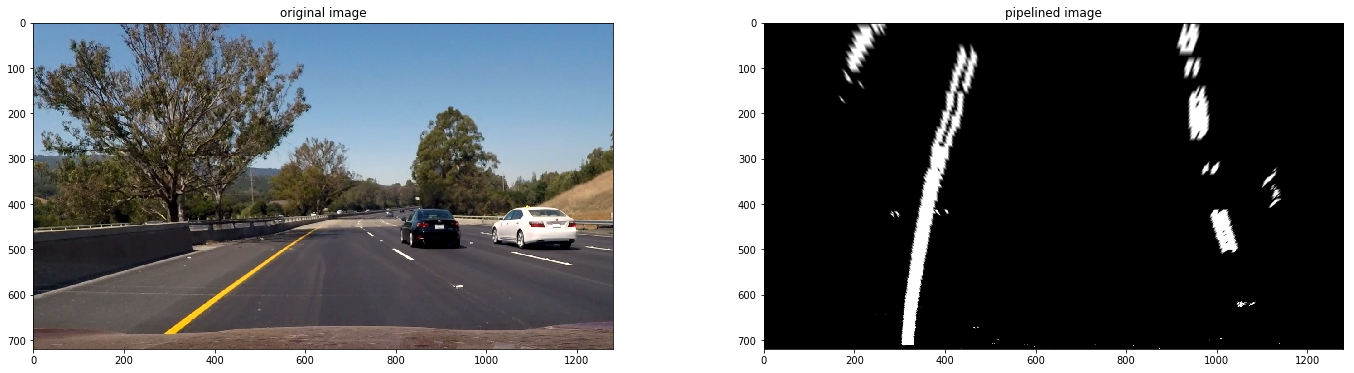

In [47]:
msk_img = warp_pipe(test_img, mtx, dist)


plt.figure(figsize=(24,6))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(test_img)
plt.subplot(1,2,2)
plt.imshow(msk_img)
plt.title("pipelined image")
plt.show()

In [48]:
def histogram_peaks(img):
    mid_point = img[img.shape[0] // 2 :, :]
    histogram = np.sum(mid_point, axis=0)
    return histogram
    
def sliding_window(img):
    hist = histogram_peaks(img)
    
    mid = np.int(hist.shape[0] // 2)
    left_x_base = np.argmax(hist[:mid])
    right_x_base = np.argmax(hist[mid:]) + mid
    
    nwindows = 10
    window_height = np.int(img.shape[0]/nwindows)
    
    nonzero = img.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
   
    left_x_current = left_x_base
    right_x_current = right_x_base
    
    margin = 80
    minpix = 40
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = left_x_current - margin
        win_xleft_high = left_x_current + margin
        win_xright_low = right_x_current - margin
        win_xright_high = right_x_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xleft_low) & (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xright_low) & (nonzero_x < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            left_x_current = np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds) > minpix:        
            right_x_current = np.int(np.mean(nonzero_x[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzero_x[left_lane_inds]
    lefty = nonzero_y[left_lane_inds] 
    rightx = nonzero_x[right_lane_inds]
    righty = nonzero_y[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, (leftx, lefty), (rightx, righty)


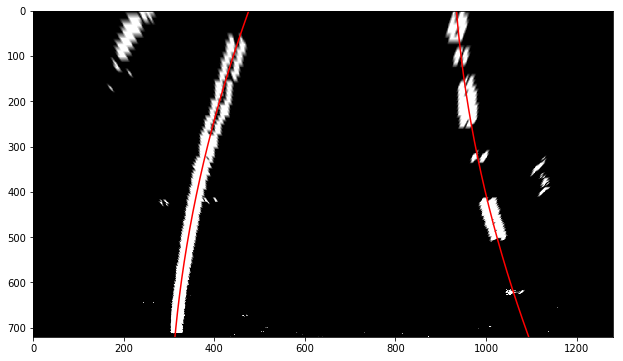

In [49]:
msk_bin_img = msk_img[:, :, 0]
plt.figure(figsize=(24,6))
left_fit, right_fit, left_ind, right_ind = sliding_window(msk_bin_img)
x = test_img.shape[0]

left_fit_x_int = left_fit[0]*x**2 + left_fit[1]*x + left_fit[2]
right_fit_x_int = right_fit[0]*x**2 + right_fit[1]*x + right_fit[2]

out_img = np.uint8(np.dstack((msk_bin_img, msk_bin_img, msk_bin_img))*255)
ploty = np.linspace(0, msk_bin_img.shape[0]-1, msk_bin_img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
nonzero = msk_bin_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
plt.imshow(msk_img)
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.show()

Draw lane onto the original image

In [50]:
def draw_lane(org_img, msk_bin_img, left_fit, right_fit):
    
    new_img = np.copy(org_img)
    # if there is no left and right fit then return the original image
    if left_fit is None or right_fit is None:
        return original_img
    
    # An image of the shape of original image to draw the lane and overlay on top of original image
    warp_zero = np.zeros_like(msk_bin_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    y,x = msk_bin_img.shape
    ploty = np.linspace(0, y-1, num=y)
    left_fit = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # stack x and y coodinates, which can be used in fill poly function
    pts_left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(0,255,0), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,0), thickness=15)

    # Warp the blank back to original image space
    inv_warp = img_warp(color_warp, top_view=False) 
    
    # Combine the lane image with the original image
    result = cv2.addWeighted(new_img, 1, inv_warp, 0.25, 0)
    return result, ploty
    

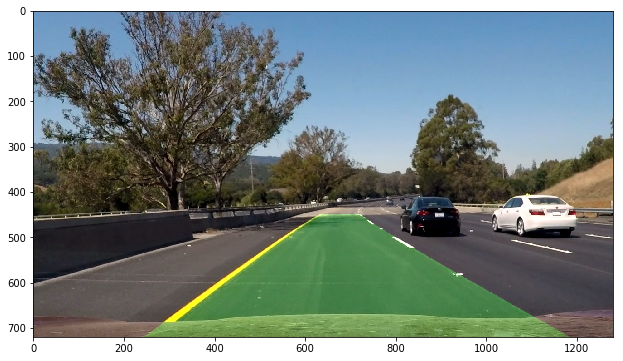

In [51]:
lane_img, ploty = draw_lane(test_img, msk_bin_img, left_fit, right_fit)
plt.figure(figsize=(12,6))
plt.imshow(lane_img)
plt.show()

Calculation of Radius of curvature

In [78]:
def radius_of_curvature(ploty, l_fit, r_fit, left_lane_inds, right_lane_inds, img_shape):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2 * l_fit[0] * y_eval + l_fit[1]) ** 2) ** 1.5) / np.absolute(2 * l_fit[0])
    right_curverad = ((1 + (2 * r_fit[0] * y_eval + r_fit[1]) ** 2) ** 1.5) / np.absolute(2 * r_fit[0])

    # Define conversions in x and y from pixels space to meters
    y_met_per_pix = 30 / 720 # meters per pixel in y dimension
    x_met_per_pix = 3.7 / 800 # meters per pixel in x dimension

    # Extract left and right line pixel positions
    leftx = left_lane_inds[0]
    lefty = left_lane_inds[1] 
    rightx = right_lane_inds[0]
    righty = right_lane_inds[1]
    
    # Fit new polynomials to x,y in world space
    left_fit = np.polyfit(lefty * y_met_per_pix, leftx * x_met_per_pix, 2)
    right_fit = np.polyfit(righty * y_met_per_pix, rightx * x_met_per_pix, 2)
    
    # Calculate radius of curvature
    left_curve_radians = ((1 + (2 * left_fit[0] * y_eval * y_met_per_pix + left_fit[1]) ** 2) ** 1.5) \
                        / np.absolute(2 * left_fit[0])
    right_curve_radians = ((1 + (2 * right_fit[0] * y_eval * y_met_per_pix + right_fit[1]) ** 2) ** 1.5) \
                        / np.absolute(2 * right_fit[0])
    print(left_fit[0], left_fit[1], left_fit[2])
    print(left_curve_radians, right_curve_radians)
    radius = round(np.mean([left_curve_radians, right_curve_radians]), 0) / 1000
    radius_text = "Radius of Curvature = {} km".format(round(radius, 4))
    
    # Calculating middle of the image, aka where the car camera is
    mid_img = img_shape[1] / 2
    car_pos = mid_img * x_met_per_pix
    
    # To calculate distance from center, Finds the base of the line at the bottom of the image.
    y = img_shape[0] * y_met_per_pix
    left_base_line = (left_fit[0] * y **2) + (left_fit[1] * y) + left_fit[2]
    right_base_line = (right_fit[0] * y **2) + (right_fit[1] * y) + right_fit[2]
    mid = (left_base_line + right_base_line) / 2
    dev_from_center = (mid - car_pos) * 100
    
    if dev_from_center >= 0:
        dev_text = "Car is {} cm left of center".format(round(dev_from_center, 4))
    else:
        dev_text = "Car is {} cm right of center".format(round(dev_from_center, 4))
        
    
    return radius_text, dev_text

In [79]:
warp_img = warp_pipe(test_img, mtx, dist)
warp_bin_img = warp_img[:, :, 0]

l_fit, r_fit, l_lane_inds, r_lane_inds = sliding_window(warp_bin_img)

img_out, ploty = draw_lane(test_img, warp_bin_img, l_fit, r_fit)
rad, dev = radius_of_curvature(ploty, l_fit, r_fit, l_lane_inds, r_lane_inds, test_img.shape)
print(rad)
print(dev)

0.000494902625116 -0.0399751567108 2.2025446693
1010.4612266 968.407826601
Radius of Curvature = 0.989 km
Car is 29.4353 cm left of center


In [68]:
class Line():
    def __init__(self, n = 10):
        # length of queue to store data
        self.n = n
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [80]:
def processing_pipeline(img):
    new_img = np.copy(img)
    warp_img = warp_pipe(new_img, mtx, dist)
    warp_bin_img = warp_img[:, :, 0]
    
    l_fit, r_fit, l_lane_inds, r_lane_inds = sliding_window(warp_bin_img)
    
    img_out, ploty = draw_lane(new_img, warp_bin_img, l_fit, r_fit)
    rad, dev = radius_of_curvature(ploty, l_fit, r_fit, l_lane_inds, r_lane_inds, new_img.shape)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_out, dev, (10,50), font, 1, (255,255,255), 2)
    cv2.putText(img_out, rad, (10,100), font, 1, (255,255,255), 2)
    
    return img_out

In [81]:
from moviepy.editor import VideoFileClip
"""
left_line = Line()
right_line = Line()
"""
input_video = VideoFileClip('project_video.mp4')
processed_video = input_video.fl_image(processing_pipeline)

output_video = 'project_video_output.mp4'
%time processed_video.write_videofile(output_video, audio=False)

-0.000951250770023 0.0521992910188 0.833753300354
525.641892288 657.990225935
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 2/1261 [00:00<01:34, 13.28it/s]

-0.000951250770023 0.0521992910188 0.833753300354
525.641892288 657.990225935
-0.000958923946915 0.0527884288528 0.828364433027
521.434820819 594.76254089
-0.00100672277856 0.0543634817537 0.817427182238
496.687485631 802.988052857


  0%|          | 6/1261 [00:00<01:23, 14.98it/s]

-0.00105060071274 0.0560062098073 0.807641915456
475.952605817 699.649476703
-0.00100197714351 0.0552787315169 0.804034893013
499.030313049 667.318866264
-0.000989046965358 0.05526380197 0.804075862161
505.549278388 438.643587846
-0.000933668032703 0.0540862094997 0.800419326428
535.525011275 428.033915728


  1%|          | 10/1261 [00:00<01:17, 16.11it/s]

-0.000932895301959 0.0548713847257 0.789233084104
535.966668813 499.413725537
-0.000865483134974 0.0529702236828 0.788668889411
577.713082407 536.406257106
-0.00082294580213 0.052054716455 0.782835267241
607.580300376 691.036932015
-0.000789732931175 0.0512995789245 0.7822852799
633.140482121 635.657344724


  1%|          | 14/1261 [00:00<01:14, 16.74it/s]

-0.000697118125468 0.0490141331288 0.768557378855
717.295034048 661.351452069
-0.000713676331958 0.049516553036 0.76464258131
700.645663922 1064.33438241
-0.000684534845809 0.0487713091412 0.761318599948
730.488920252 780.462213592
-0.000718742322448 0.0493960297612 0.766558732224
695.701435016 684.108046864


  1%|▏         | 18/1261 [00:01<01:12, 17.15it/s]

-0.000768349006646 0.0506108646523 0.770880693711
650.766365992 812.960360905
-0.000763694454436 0.0507579122804 0.760425390967
654.736650711 721.345550677
-0.000707624360339 0.0489978094897 0.77000381507
706.635740113 336.642129695
-0.000683964342495 0.0483041760899 0.764740072587
731.091071057 340.572602962


  2%|▏         | 22/1261 [00:01<01:11, 17.35it/s]

-0.000637854808579 0.0467367744808 0.767147097291
783.962775994 384.341498901
-0.00056256005591 0.0444065457349 0.769863601361
888.946632192 419.889212558
-0.000525246559829 0.043137194294 0.763262888919
952.128231548 462.447895361
-0.00050958746224 0.0422444484951 0.763776229191
981.387716402 469.238041004


  2%|▏         | 26/1261 [00:01<01:10, 17.44it/s]

-0.000579614531116 0.0437396617401 0.763709392749
862.747350546 497.711874409
-0.000655717586867 0.0456652120199 0.75894650188
762.569905106 947.405913192
-0.000612094405685 0.0441233831044 0.75905288702
816.93544097 786.470941377
-0.000653486506363 0.0448218316756 0.758857658035
765.163599139 593.224449607


  2%|▏         | 30/1261 [00:01<01:10, 17.42it/s]

-0.000716710672482 0.0459558863836 0.745215167945
697.64108128 607.981766258
-0.000774942050078 0.0477526129901 0.74398350898
645.211223309 803.451326132
-0.000845718837505 0.0498048239226 0.74497900076
591.213702087 678.492731558
-0.000894703251465 0.0516089551958 0.741210067511
558.847858471 550.698100301


  3%|▎         | 34/1261 [00:01<01:09, 17.54it/s]

-0.00101392519666 0.0552434456696 0.734623849576
493.155463378 322.210615104
-0.000986880562827 0.0544728629716 0.733727365972
506.663409702 356.398227969
-0.00105836337848 0.0571216744107 0.717825284588
472.455587337 444.8358217
-0.00108520506804 0.0584260770614 0.711819175154
460.772478351 458.989130318


  3%|▎         | 38/1261 [00:02<01:09, 17.65it/s]

-0.00110809595299 0.059818926574 0.703405503388
451.253717635 421.525308186
-0.00114287646646 0.0610685400696 0.696975047374
437.528624545 682.093441212
-0.00119890125823 0.063499705485 0.68062503073
417.091978935 477.950397666
-0.0012404607 0.0654004517264 0.665379448564
403.124199818 464.425903806


  3%|▎         | 42/1261 [00:02<01:08, 17.72it/s]

-0.00125253868525 0.0660500904881 0.652778778999
399.237746609 477.635552048
-0.00127362979462 0.0669263587755 0.643943605238
392.630626546 690.813557004
-0.00124199257777 0.0665209289755 0.639109364715
402.61653688 501.906953925
-0.00116989794126 0.0650431461879 0.637400435135
427.404078515 535.679068236


  4%|▎         | 46/1261 [00:02<01:09, 17.36it/s]

-0.00113608300022 0.0641173901195 0.63447962203
440.119004605 415.146547156
-0.00108082557574 0.0626266985585 0.636607408723
462.612490628 299.890416126
-0.00104608323913 0.061715913813 0.635790408124
477.974099237 816.641260483
-0.000994923276954 0.0603474902929 0.633052901748
502.551721077 493.725267865


  4%|▍         | 50/1261 [00:02<01:11, 16.88it/s]

-0.000982470615087 0.0599981667886 0.636788087991
508.92205126 477.124837528
-0.000918135221133 0.0583660208937 0.63018674983
544.59128417 424.018495949
-0.000869606487243 0.0569061702351 0.635839241029
574.992601396 544.399209225
-0.000811814249753 0.0551688915425 0.64308537407
615.943805523 598.064785336


  4%|▍         | 54/1261 [00:03<01:11, 16.82it/s]

-0.000780018066346 0.0538447679351 0.658341227548
641.05938325 511.727973532
-0.000799796221224 0.0539950490432 0.66034767672
625.193838648 513.727306756
-0.000784318553209 0.0534478095019 0.662702347757
637.535908605 702.179142975
-0.000707754225307 0.0508348394044 0.675720968147
706.535211804 536.963637414


  5%|▍         | 58/1261 [00:03<01:10, 17.03it/s]

-0.000645470148283 0.0486163765398 0.686746592722
774.744014175 561.853475564
-0.000599873246486 0.0467022260524 0.703206560521
833.654169024 558.458113562
-0.000605213535399 0.0465806353292 0.704748018048
826.286628944 779.00128616
-0.000659899183734 0.0478292894202 0.711632688923
757.769611465 660.778921344


  5%|▍         | 62/1261 [00:03<01:10, 16.98it/s]

-0.000677199280752 0.0476918078647 0.727429442719
738.391188266 649.09387241
-0.000721263768897 0.0486914752751 0.726948027333
693.258845995 582.240286914
-0.000735318964118 0.0484402594098 0.739893963384
679.996611714 593.336125638
-0.000730560153011 0.0480130156204 0.741259116092
684.424797906 589.028361692


  5%|▌         | 66/1261 [00:03<01:11, 16.71it/s]

-0.000752327808587 0.0481492663308 0.751116879598
664.613315555 475.486257223
-0.000730869574545 0.0468129245189 0.760317556356
684.125957945 539.14721765
-0.000802635162275 0.0481845660194 0.761558325645
622.948046679 749.431175989
-0.000834800637836 0.0487833300231 0.759070477193
598.946768269 652.528539399


  6%|▌         | 70/1261 [00:04<01:11, 16.55it/s]

-0.000720780508623 0.0453316879772 0.772460853408
693.697241451 625.665909507
-0.000724899359101 0.0450026631226 0.784354298562
689.753467572 331.93184738
-0.000716893420872 0.0446962135184 0.778504301399
697.456919369 435.171663065
-0.000718305612013 0.0447460143539 0.778997010936
696.085591425 472.87490103


  6%|▌         | 74/1261 [00:04<01:13, 16.23it/s]

-0.000683226930771 0.0434698360487 0.781666570666
731.828313767 486.143184373
-0.000639485464014 0.04206496144 0.785638551195
781.895086164 513.290415106
-0.000603648738056 0.0410061283572 0.788846331591
828.325348325 549.562310103
-0.000560295372391 0.039725052135 0.784631210294
892.437148136 563.353367874


  6%|▌         | 78/1261 [00:04<01:11, 16.56it/s]

-0.000554265890842 0.0392534662057 0.79315948963
902.143543845 502.13310268
-0.00044124081603 0.0358818071267 0.79102936189
1133.31966807 524.462345522
-0.000414755500163 0.0345179669211 0.795010866406
1205.69851999 533.093451336
-0.000390010406549 0.0332807320712 0.795930001364
1282.20603417 537.902606465


  7%|▋         | 82/1261 [00:04<01:10, 16.80it/s]

-0.000449130393823 0.0345261722284 0.792576610797
1113.35929953 584.091683503
-0.000375631336889 0.0319857724103 0.814477691115
1331.27176504 591.794328412
-0.000372377048079 0.0313558266182 0.815874435896
1342.8898276 343.869950281
-0.000419198239142 0.0324715897988 0.809393032968
1192.84987812 455.754511639


  7%|▋         | 86/1261 [00:05<01:09, 16.94it/s]

-0.000371271063454 0.030682675764 0.804775838589
1346.86874859 715.892796479
-0.00040904055038 0.0313551710421 0.807051712581
1222.4586516 616.545192815
-0.000481635082071 0.0334047089192 0.802420890002
1038.16254947 576.655785427
-0.000650789052205 0.0380325164664 0.806752581327
768.299175228 583.878176925


  7%|▋         | 90/1261 [00:05<01:08, 16.99it/s]

-0.00073864105494 0.0403092544636 0.812254467541
676.934601305 639.571461553
-0.000857885516588 0.0440545856293 0.805513137567
582.875541421 553.901369472
-0.000899224169838 0.045368648913 0.816010675562
556.095277596 511.349428395
-0.000935559294808 0.0460647358769 0.809569873774
534.519690611 674.892633787


  7%|▋         | 94/1261 [00:05<01:08, 17.08it/s]

-0.000930820646168 0.0461850076808 0.805930624001
537.234462642 617.731839186
-0.000936292690185 0.0466922355629 0.812199299346
534.09193482 637.155174583
-0.000959098353851 0.0477797613757 0.808311432742
521.396337209 441.623927463
-0.000940148189585 0.0475902883546 0.801298452074
531.891993951 361.356217134


  8%|▊         | 98/1261 [00:05<01:10, 16.58it/s]

-0.000925941113267 0.0474077940926 0.799300528665
540.043913806 528.865972192
-0.000887758132715 0.0464797091572 0.804025433908
563.25452636 546.733809773
-0.000883937545263 0.0464709299278 0.79706391403
565.686579626 538.930840223
-0.000879437785652 0.0466326300538 0.799826796606
568.576372653 569.3289279


  8%|▊         | 102/1261 [00:06<01:08, 16.85it/s]

-0.000884386889499 0.0469198084546 0.795392377937
565.394667413 600.811167796
-0.000886985772206 0.0472589944695 0.796107813304
563.736197048 506.20074668
-0.000893177812816 0.0475667370436 0.799297467004
559.828670702 483.73978872
-0.000901538651253 0.0473136158992 0.807634002496
554.644776596 516.447137596


  8%|▊         | 106/1261 [00:06<01:09, 16.55it/s]

-0.000921783991206 0.0481594968053 0.803871251292
542.467109028 593.689686512
-0.00089228973658 0.0476224118752 0.792952112949
560.384776722 548.769727531
-0.000861523806305 0.046986762874 0.792321218838
580.385700375 561.242510243
-0.000833686867765 0.046261974111 0.79223025688
599.75781092 436.80333663


  9%|▊         | 110/1261 [00:06<01:09, 16.45it/s]

-0.000886810804917 0.0482155418357 0.792924576831
563.838584594 510.439732909
-0.000893023516071 0.0484416761726 0.794842529479
559.917218523 477.925994957
-0.000893754430191 0.0486378649507 0.795933123767
559.458041063 426.589445632
-0.000915339350417 0.0494231179233 0.793796079156
546.269577593 454.369146782


  9%|▉         | 114/1261 [00:06<01:08, 16.82it/s]

-0.000868513820315 0.0479478951811 0.792131795872
575.710527403 453.01487063
-0.000943210659119 0.0503266119318 0.789085861736
530.134714475 598.096424147
-0.000933087352204 0.0501548038358 0.794878073155
535.882111165 477.361870067
-0.0010204183718 0.0532536640495 0.783147784103
490.040811751 422.538842522


  9%|▉         | 118/1261 [00:06<01:07, 16.96it/s]

-0.00106058681443 0.0544756792374 0.776746386906
471.495316322 434.38244321
-0.00107765196628 0.0552414357547 0.768693776018
464.032242362 478.74580557
-0.00104487678271 0.0546792453402 0.770629496597
478.570419551 492.168464908
-0.00104370344002 0.0549077891724 0.769101196222
479.105093326 489.06737734


 10%|▉         | 122/1261 [00:07<01:07, 16.76it/s]

-0.00109429701575 0.0570791552126 0.759460212938
456.963714322 331.156237575
-0.00109138677489 0.0573717453908 0.751926651895
458.176934833 420.340136544
-0.00109918740046 0.057970149941 0.748580405756
454.923958931 477.946132555
-0.00112397771725 0.0590620594234 0.746765407798
444.894456992 455.916471433


 10%|▉         | 126/1261 [00:07<01:06, 16.96it/s]

-0.00109767374767 0.0583143439744 0.753920866223
455.546723267 559.888057969
-0.00109060951675 0.0583310970976 0.754650697228
458.49306844 428.114061872
-0.00101332526192 0.0562431149334 0.753922110168
493.439784506 472.556106874
-0.00104011335532 0.0573883033149 0.748152708531
480.734373524 463.882563459


 10%|█         | 130/1261 [00:07<01:06, 17.14it/s]

-0.0010213731492 0.0569364653587 0.744255971509
489.550382568 483.07920073
-0.00105747638677 0.0582647298811 0.743389645576
472.842213057 516.390122556
-0.000999160881359 0.0564374728192 0.751346093365
500.42873721 507.730269045
-0.000961440108759 0.0554552892784 0.756175539677
520.056803893 524.298164316


 11%|█         | 134/1261 [00:07<01:07, 16.76it/s]

-0.000965868109193 0.0556810037561 0.763260073405
517.672748765 339.088877233
-0.000937503003578 0.0548749028912 0.768784332732
533.332970716 446.927016602
-0.000907014719011 0.0540498530038 0.775755697226
551.259042423 617.250320526
-0.000890292780054 0.0536283923714 0.779222631464
561.613069462 599.479147191


 11%|█         | 138/1261 [00:08<01:05, 17.04it/s]

-0.000837636733556 0.0518440626132 0.79020795375
596.919924692 539.726550804
-0.000816840091211 0.0509956723227 0.792434776906
612.118782522 663.226107025
-0.000763117793011 0.0491456497083 0.798531339031
655.218353009 714.473253678
-0.000745440766624 0.0483310109393 0.802754560549
670.757632069 659.456325359


 11%|█▏        | 142/1261 [00:08<01:05, 17.08it/s]

-0.00069981026995 0.0466173205758 0.805308608114
714.502912707 657.490988171
-0.000751697646798 0.047613816758 0.802946157
665.167668889 623.012948566
-0.000730035103457 0.0463575152723 0.816447355931
684.905604122 884.168682865
-0.000722433248951 0.0461108169286 0.829948345061
692.113750733 676.639694873


 12%|█▏        | 146/1261 [00:08<01:06, 16.81it/s]

-0.000722509096349 0.0459548367863 0.829696930176
692.040179434 636.45796953
-0.000725388932714 0.0458105416326 0.831780356637
689.291097601 478.171826071
-0.000777483532375 0.0471278512978 0.834942732003
643.100722819 508.986212563
-0.000747099396808 0.0462293051853 0.838564154052
669.257147207 590.896457794


 12%|█▏        | 150/1261 [00:08<01:05, 16.98it/s]

-0.000850968386923 0.0493160171463 0.843363423079
587.568354238 562.597633224
-0.000857143316347 0.0494071792612 0.845868176037
583.336347978 541.165314117
-0.000806194683232 0.0479872814073 0.845878952962
620.197684094 617.478019717
-0.000785531725509 0.0472710515355 0.844699681542
636.511569376 515.79504369


 12%|█▏        | 154/1261 [00:09<01:04, 17.05it/s]

-0.000726573943772 0.0453208706678 0.847095560839
688.164500346 522.290499546
-0.000830426397955 0.0480606619731 0.838755397498
602.102917046 487.296986072
-0.000781693925302 0.0465464255911 0.834108332577
639.636623646 741.036776718
-0.000725045019556 0.0454233762286 0.82393652567
689.616410115 619.987885138


 13%|█▎        | 158/1261 [00:09<01:04, 17.15it/s]

-0.000712872935431 0.045005383323 0.82099151862
701.392795999 644.121655475
-0.000750971300519 0.046325140027 0.807896701527
665.806170248 552.843015846
-0.00080341314676 0.047835858512 0.80332422667
622.344892425 562.139179395
-0.000799173769835 0.0476238611864 0.794309531399
625.646223087 627.570143479


 13%|█▎        | 162/1261 [00:09<01:04, 17.16it/s]

-0.000862127869376 0.0498306563872 0.776759411304
579.963270185 623.321479484
-0.000821584866985 0.0488490898383 0.765598072515
608.579986064 632.753302622
-0.000815678956157 0.0488990510479 0.75397128916
612.98626959 762.856627177
-0.000813847362944 0.0491103552977 0.740717475946
614.365928117 695.790844646


 13%|█▎        | 166/1261 [00:09<01:03, 17.17it/s]

-0.000857533593745 0.0508144650867 0.729035852626
583.067816807 576.764426415
-0.000884992612946 0.0511748932562 0.736520089324
564.979370562 470.888052776
-0.000916863676522 0.0523089683598 0.721188101215
545.342984437 816.801890587
-0.000943569971534 0.0532084055186 0.718972470937
529.911207025 635.15855717


 13%|█▎        | 170/1261 [00:10<01:03, 17.19it/s]

-0.000792294124009 0.0491566368786 0.723449287799
631.081456121 590.420327634
-0.00077294691853 0.0486725565639 0.715140039022
646.880355899 618.958246729
-0.000739071411019 0.0476431264875 0.707391033756
676.536072079 393.197340565
-0.000715719490801 0.0469055515726 0.703491873336
698.61466537 375.241522464


 14%|█▍        | 174/1261 [00:10<01:06, 16.37it/s]

-0.000718597828507 0.0469329915655 0.699705836465
695.815174472 307.907351567
-0.000722821251055 0.0468291543247 0.703773096664
691.746808361 308.314074233
-0.000777280781281 0.0483623398866 0.702152585873
643.271280898 361.099720752
-0.000811197357105 0.0496534139451 0.694139132976
616.373834546 311.115272114


 14%|█▍        | 178/1261 [00:10<01:04, 16.77it/s]

-0.000791881562612 0.0485796525923 0.703596382099
631.408768618 305.485761903
-0.000723130219079 0.0464243740179 0.700678335375
691.448344369 311.853301079
-0.000777126614581 0.0476883764085 0.692195338335
643.397022762 333.759967838
-0.00079381337432 0.0479166334623 0.693843844568
629.871088284 438.459213853


 14%|█▍        | 182/1261 [00:10<01:04, 16.82it/s]

-0.000729394364007 0.0457391834084 0.708430558164
685.504487803 369.840094075
-0.00082643922646 0.0486589490892 0.701273854605
605.005833222 387.023628592
-0.000851940676271 0.0492021001156 0.696520085919
586.898316244 403.533576878
-0.000953701785214 0.0518786370119 0.697403386528
524.294690571 417.784766477


 15%|█▍        | 186/1261 [00:11<01:03, 17.05it/s]

-0.00104544902022 0.0547018385465 0.690159765474
478.308602082 430.379996699
-0.00114019289293 0.0578075873544 0.678011087126
438.594937951 430.521534271
-0.00130317495339 0.0631444485652 0.66481379646
383.806758722 372.631356506
-0.00132426447695 0.0641910498438 0.657756478304
377.698157668 383.869911178


 15%|█▌        | 190/1261 [00:11<01:02, 17.16it/s]

-0.00136003766552 0.065919245168 0.650986181073
367.770566111 444.138269798
-0.00132482835957 0.0650669203461 0.65805634967
377.523350399 391.440160428
-0.00135790489764 0.0663417404741 0.652522259235
368.338899927 487.06668471
-0.00136765012663 0.067439220942 0.647569733183
365.705974491 441.260587307


 15%|█▌        | 194/1261 [00:11<01:02, 17.20it/s]

-0.00120942101498 0.0631047733903 0.666563373522
413.475289635 424.533228557
-0.00120909212095 0.0636563008445 0.667908400241
413.581331265 266.639649992
-0.00115010004979 0.0620547119801 0.675913172678
434.775434009 289.175440926
-0.00112911186314 0.06144889476 0.678211383466
442.851484649 359.751007403


 16%|█▌        | 198/1261 [00:11<01:03, 16.87it/s]

-0.000988667519157 0.0570293930994 0.680584562647
505.734888277 443.547847825
-0.000880242481814 0.05370404724 0.676256101483
568.026090132 476.332602665
-0.000775710230773 0.0503385303674 0.671105317246
644.584998551 434.30034908
-0.00070632183122 0.0484469049778 0.654640438208
707.93245834 430.514906711


 16%|█▌        | 202/1261 [00:11<01:02, 17.03it/s]

-0.000698441769885 0.048130312496 0.655393413032
715.921669619 493.1774549
-0.000655217040994 0.0464193867742 0.65800712975
763.164613831 772.888499822
-0.000716512659046 0.0475806968134 0.661212639377
697.847006868 514.7495763
-0.000864156983646 0.0515954897217 0.647695663899
578.598604516 514.498998429


 16%|█▋        | 206/1261 [00:12<01:01, 17.12it/s]

-0.000832822336743 0.0505428140481 0.652597305854
600.368515477 745.499457593
-0.000821932054144 0.0502752498879 0.665631440267
608.323753516 482.981199747
-0.000841735017275 0.0508960968016 0.666823042609
594.011357397 514.938217632
-0.000917162757243 0.053165539211 0.67495737175
545.162124404 364.012043324


 17%|█▋        | 210/1261 [00:12<01:01, 17.16it/s]

-0.00096648397256 0.054893364933 0.670496324455
517.346207989 535.130321076
-0.000970282559122 0.05529432958 0.66022848235
515.320049857 466.234670469
-0.000900914092657 0.0531175077947 0.665222105241
554.992492288 503.501840129
-0.000866516808616 0.052125667813 0.657135995693
577.022888794 434.845122784


 17%|█▋        | 214/1261 [00:12<01:02, 16.79it/s]

-0.00091427171184 0.053881697864 0.64681841267
546.884037741 536.819087212
-0.000948540088072 0.0550939220241 0.634852036414
527.128242152 605.460743846
-0.00102350605306 0.0573728355027 0.619972849862
488.528342041 565.017364937
-0.00108483624332 0.05916057699 0.607254076543
460.922628129 598.438412898


 17%|█▋        | 218/1261 [00:12<01:01, 16.95it/s]

-0.0011109766432 0.0603412455858 0.589787988982
450.080624267 796.636647304
-0.00104130674002 0.0585598365983 0.595860851156
480.176486714 632.721525374
-0.000997887834861 0.0575327829891 0.585613053234
501.062147659 640.654952692
-0.00101888583713 0.0583629156839 0.585084588579
490.737421237 462.608647942


 18%|█▊        | 222/1261 [00:13<01:00, 17.13it/s]

-0.000923470311902 0.0555002103659 0.58655371749
541.435945437 628.093100363
-0.000851684148289 0.0534176662536 0.593193670818
587.077118265 533.518313453
-0.000812242030946 0.0522513689392 0.598094938517
615.591926597 523.058567741
-0.000764326674806 0.0507268469837 0.603720628809
654.19440695 482.699630808


 18%|█▊        | 226/1261 [00:13<01:00, 17.17it/s]

-0.000818935491193 0.0523466872044 0.605766573128
610.558546195 615.386246067
-0.000768499646432 0.0505964009539 0.611889751208
650.638594881 617.274171299
-0.000781506603846 0.0504353851695 0.625718009317
639.802366693 541.210460802
-0.000797569894129 0.0507039350471 0.617375120479
626.912301838 539.74617467


 18%|█▊        | 230/1261 [00:13<00:59, 17.19it/s]

-0.000760423911555 0.0493425670754 0.617824329679
657.542078283 799.022057295
-0.000707389443001 0.0477114258206 0.622682984205
706.854318879 615.492830585
-0.000643569850018 0.0455723660301 0.621725103342
776.973741864 638.484701338
-0.000639196555417 0.0450902042668 0.627916492322
782.286123606 479.336334263


 19%|█▊        | 234/1261 [00:13<00:59, 17.24it/s]

-0.000553916497867 0.042155095902 0.632167164782
902.771985631 517.940415561
-0.000539948825717 0.0412872522356 0.636995569566
926.124583135 414.512385974
-0.000523028952137 0.0405833363219 0.636650536693
956.092591835 477.3945806
-0.000514440854102 0.0397178255668 0.643510145729
972.044362094 439.084440752


 19%|█▉        | 238/1261 [00:14<00:59, 17.15it/s]

-0.000579814822668 0.0413953322234 0.647574797631
862.401572363 401.400073875
-0.000577542339994 0.0411969306528 0.644786206249
865.79383312 414.025248449
-0.000625352492329 0.0424429903263 0.642667512328
799.578735847 362.495904087
-0.000694346004172 0.0440135680127 0.639444575549
720.108354479 390.73122966


 19%|█▉        | 242/1261 [00:14<00:59, 17.17it/s]

-0.000681367607016 0.0433983907415 0.640082232424
733.825559874 456.867127995
-0.000675399207538 0.0432425673117 0.640079935567
740.311462428 434.208064951
-0.000613037212137 0.040904865858 0.643196283674
815.632485449 464.566546574
-0.000715004902911 0.0439344977108 0.639029590313
699.297159002 332.344571135


 20%|█▉        | 246/1261 [00:14<01:00, 16.77it/s]

-0.000696691283272 0.0430564483608 0.64270769449
717.67984621 304.867682857
-0.000737348501739 0.0438954031992 0.648150910029
678.10548111 465.063852985
-0.00077788472104 0.045120374355 0.644247957637
642.770897575 449.512184478
-0.000770284167711 0.0447122205038 0.642535954911
649.113116355 419.028589558


 20%|█▉        | 250/1261 [00:14<01:00, 16.65it/s]

-0.000839618754301 0.0470240537889 0.639934579334
595.518003303 393.296354556
-0.000772134341002 0.0447294397402 0.647449336176
647.557994707 405.125533875
-0.000802510850272 0.0456442930344 0.645720742117
623.050097256 418.628728119
-0.000770923957187 0.0440481375119 0.653903029095
648.576866577 417.237412903


 20%|██        | 254/1261 [00:15<01:00, 16.71it/s]

-0.00072186962147 0.0425048833571 0.661574626935
692.64643336 507.950130277
-0.000733164059607 0.0426766829559 0.667054217935
681.977204415 479.614490156
-0.000679199468191 0.0408815936873 0.672791402969
736.160803161 502.570246536
-0.000701766639725 0.0411966790285 0.690861933765
712.488332504 475.180252849


 20%|██        | 258/1261 [00:15<00:59, 16.92it/s]

-0.0006815804312 0.0401798687351 0.701703221038
733.589613187 339.59348269
-0.000717917958999 0.0408605127957 0.713478178341
696.463260055 459.93952452
-0.000722195107157 0.040417471804 0.732715867156
692.342144478 417.455907631
-0.000725121183244 0.0405063786227 0.733485833784
689.54885931 410.581159815


 21%|██        | 262/1261 [00:15<00:59, 16.76it/s]

-0.000748755721909 0.0408438929998 0.74968255564
667.790709326 366.856243875
-0.00069482118036 0.0392378490401 0.752895093219
719.615795895 434.917008956
-0.000651525876982 0.0377094072862 0.773668966314
767.431256466 421.758485874
-0.000713517162527 0.039040975115 0.773477575461
700.76846456 437.085696315


 21%|██        | 266/1261 [00:15<00:58, 16.96it/s]

-0.000715477310598 0.0387431942848 0.780640446063
698.852024304 535.695908335
-0.000675303414092 0.0375547925474 0.78909596013
740.417311928 536.536205119
-0.000656967128962 0.0369225547364 0.781313733819
761.079886376 559.424354021
-0.000718747133278 0.0385401077339 0.787077235103
695.676312929 556.63331016


 21%|██▏       | 270/1261 [00:15<00:58, 17.05it/s]

-0.000709423378072 0.0379489041856 0.792662332321
704.819706849 467.467164303
-0.000661016604554 0.0361928288866 0.796277567317
756.42386807 501.746077052
-0.000683593834118 0.0365867831244 0.802587061609
731.449451588 529.729094983
-0.000686681661746 0.0361417434119 0.821584960879
728.16676558 542.435087962


 22%|██▏       | 274/1261 [00:16<00:57, 17.06it/s]

-0.000761475541603 0.0381965049717 0.834711691782
656.674260701 552.929436553
-0.000729421604767 0.037150688337 0.84829221543
685.51878848 533.25319494
-0.000762138189419 0.0377847743962 0.867902527951
656.110110384 542.132493088
-0.000760395772426 0.0375914182185 0.868988384928
657.614951521 557.880104393


 22%|██▏       | 278/1261 [00:16<00:57, 17.00it/s]

-0.000722183582139 0.036370993047 0.872989745581
692.39417599 723.937058303
-0.000660726916081 0.0347684945116 0.880878565691
756.768662915 686.629932954
-0.000630093819647 0.033870933275 0.883048779707
793.550560233 701.812419732
-0.000651443303313 0.0342105654665 0.901884552114
767.553269 499.878780976


 22%|██▏       | 282/1261 [00:16<00:57, 16.94it/s]

-0.000657333230399 0.0341460083089 0.911407063091
760.680525479 596.594630591
-0.000632272213447 0.0330680226016 0.92651413573
790.826138046 719.53461704
-0.00063358490529 0.0327015393937 0.948057016965
789.192975772 641.731712039
-0.000600659362242 0.0318024899139 0.950683866779
832.44044765 664.05472037


 23%|██▎       | 286/1261 [00:16<00:57, 16.97it/s]

-0.000586925455816 0.0310381775487 0.971573387421
851.918720015 635.758042581
-0.000553211047194 0.0300852336001 0.978141777891
903.826905394 653.770588042
-0.000509757988348 0.0287189021973 0.983132739665
980.862501283 723.123251528
-0.000533041253223 0.0287616346292 0.996517806991
938.027899775 666.502488537


 23%|██▎       | 290/1261 [00:17<00:57, 16.91it/s]

-0.000502058038831 0.0275550030431 1.00660447578
995.910331619 727.002171841
-0.000466104281919 0.0257128584958 1.04956016183
1072.72921017 833.813480689
-0.000451705803504 0.0250256492574 1.05651829765
1106.92205953 758.015648952
-0.00047273169633 0.0249393575665 1.08738813981
1057.70059071 479.443769479


 23%|██▎       | 294/1261 [00:17<00:57, 16.94it/s]

-0.000468891154054 0.0244784306707 1.10431582419
1066.36647356 622.329078669
-0.00046555352533 0.0243560819596 1.10487878376
1074.010533 748.059560493
-0.000449570029458 0.0235265234143 1.12335769899
1112.19318334 670.742022168
-0.000446132354301 0.0237820890996 1.11447428125
1120.75825975 661.698911815


 24%|██▎       | 298/1261 [00:17<00:56, 16.93it/s]

-0.000434502490236 0.0232126338906 1.12788807063
1150.75513047 794.52025564
-0.000419745598663 0.0228961586062 1.12344235202
1191.20679437 821.272495123
-0.000372349600285 0.0217511107877 1.11852222194
1342.82468369 811.825553283
-0.000373742179069 0.0215094298242 1.11806884409
1337.82220481 780.468370946


 24%|██▍       | 302/1261 [00:17<00:57, 16.62it/s]

-0.000377055428871 0.0218085682331 1.10481124268
1326.06620122 767.218154262
-0.000337728763861 0.0204569073344 1.11802359
1480.47809438 1131.51826667
-0.000305836486059 0.0202537347703 1.09331150977
1634.86965639 1149.05999335
-0.000295605948673 0.0196655782515 1.09993152549
1691.45061326 1125.41483682


 24%|██▍       | 306/1261 [00:18<00:58, 16.45it/s]

-0.000288801587174 0.0191861064719 1.10797993898
1731.30162323 1118.05075442
-0.000274862580248 0.0189231806345 1.10087551637
1819.10726939 1728.95381043
-0.00023207113015 0.0162496305463 1.15337798143
2154.52961729 20897.1531805
-0.000225026264607 0.0167504272596 1.13216566832
2221.99843569 3771.68660836


 25%|██▍       | 310/1261 [00:18<00:59, 16.02it/s]

-0.000196251112399 0.0139341110535 1.20443663235
2547.77434461 3970.16560335
-0.000162114921345 0.0126551124587 1.21957841483
3084.2718621 2157.08154238
-0.000126437450612 0.0107669204824 1.2519680135
3954.58493876 1774.04322758
-8.82005041825e-05 0.00864614325056 1.29314164135
5668.99791825 1415.35032177


 25%|██▍       | 314/1261 [00:18<00:57, 16.38it/s]

-8.3864518678e-05 0.00798467752529 1.30728040755
5962.07523976 2393.19139009
-4.44723657465e-05 0.00524397905796 1.36739834237
11243.049057 2145.53066908
-2.99130926232e-05 0.00485686248794 1.3687820219
16715.3242898 1911.42334893
-4.14378003291e-08 0.00350122982993 1.38511070128
12066499.1138 823.438637378


 25%|██▌       | 318/1261 [00:18<00:56, 16.64it/s]

1.73037785713e-05 0.00296910896433 1.38389480767
28896.118462 1202.76777878
-3.24287991252e-06 0.00372791178522 1.37711180374
154186.827238 1141.14127827
2.10950273316e-05 0.0015595746349 1.42864688941
23702.5518547 795.288125078
3.28941130941e-05 0.00123350470993 1.4288015841
15200.522348 924.880679695


 26%|██▌       | 322/1261 [00:19<00:56, 16.74it/s]

1.79456556813e-05 0.000827433307627 1.45669264373
27862.0477299 841.831207236
4.76703672496e-05 0.00031740088514 1.45080458136
10488.8546682 1054.6775649
8.68821984599e-05 -0.00109261085222 1.46110098405
5755.06486936 1005.75744938
6.37200623535e-05 -0.000874815279709 1.46905901058
7846.92415277 983.666962574


 26%|██▌       | 326/1261 [00:19<00:55, 16.75it/s]

5.48737284622e-05 0.00022846505258 1.43441696652
9111.99744211 1140.17195883
0.00011551794845 -0.00228534176469 1.46440572155
4328.47126291 1429.34342069
0.000118290731949 -0.00263571019984 1.47112177959
4226.99949724 1888.84329321
0.000103522049459 -0.00192973992338 1.45345437207
4830.02120118 1728.44959531


 26%|██▌       | 330/1261 [00:19<00:56, 16.41it/s]

9.22288264043e-05 -0.00175138889505 1.45229671531
5421.41438363 2122.15120652
6.67401477333e-05 -0.000225767229655 1.41365327743
7491.9024623 2308.31184146
7.27777784123e-05 -0.00124550457938 1.44307914703
6870.32894929 3848.06431739
7.55484071621e-05 -0.0022223056587 1.46948831059
6618.32593362 1854.62006554


 26%|██▋       | 334/1261 [00:19<00:55, 16.61it/s]

8.07705966023e-05 -0.00393057869197 1.52352931517
6190.37918059 1455.78019932
4.79861131642e-05 -0.00348002557493 1.53601808792
10419.6868931 1525.71356172
4.07811916671e-05 -0.00285581492199 1.52570006605
12260.5570627 1475.88341556
2.0829514584e-05 -0.00221198101594 1.52210146713
24004.4334628 2063.97902744


 27%|██▋       | 338/1261 [00:20<00:55, 16.75it/s]

1.04739334339e-05 -0.000435062560052 1.47064301274
47737.5601964 1888.10656867
1.14605934439e-05 -0.00054280118089 1.47161568179
43627.7595897 2934.19208967
7.45498198748e-05 -0.00205089225788 1.47609190374
6706.98303791 3458.65990897
5.68471514416e-05 -0.00177955348685 1.48161823588
8795.55037573 3158.33962858


 27%|██▋       | 342/1261 [00:20<00:54, 16.81it/s]

5.74511020677e-05 -0.00265297828177 1.51331671218
8703.06137308 3350.2886443
2.64010670113e-05 -0.0015919758684 1.50850346721
18938.6284979 5062.50352078
1.88416369375e-05 -0.00239561278991 1.54710081596
26537.0363003 1571.48851232
-6.37305008911e-08 -0.00104311192803 1.51884649934
7845549.85536 1459.00073259


 27%|██▋       | 346/1261 [00:20<00:54, 16.85it/s]

-6.11547836454e-06 -9.05086583144e-05 1.49363730651
81759.7785132 1371.47055623
-2.99486849152e-05 0.00133350368464 1.47331693288
16695.2292147 1928.29052671
-2.19138038846e-05 0.00174401155151 1.45220611949
22816.6749123 1827.32386914
-3.35324482299e-05 0.00161300317479 1.46876170733
14910.9338594 1775.14816862


 28%|██▊       | 350/1261 [00:20<00:54, 16.80it/s]

-5.50294600003e-05 0.00286255841425 1.44156975645
9086.04485071 2299.66075491
-4.80481231573e-05 0.00210210045913 1.45844733322
10406.2431514 3034.38266815
-6.68680620297e-06 0.00172926660773 1.44018527768
74774.3105958 2648.81159411
-4.45351881425e-06 0.00126505674577 1.44922956934
112270.940841 2515.00209985


 28%|██▊       | 354/1261 [00:20<00:55, 16.36it/s]

-1.17508156018e-05 0.00142437904155 1.44827420317
42550.2710685 1150.41248922
-5.98776327985e-05 0.0035263302443 1.41741416895
8350.36355736 1175.40333756
-4.10452942894e-05 0.00245347313776 1.43434898146
12181.664395 1599.80165587
-3.68747602058e-05 0.0023955378247 1.42840493948
13559.4109139 2828.90468016


 28%|██▊       | 358/1261 [00:21<00:54, 16.61it/s]

-4.03913013583e-05 0.00219505796858 1.43695200488
12378.9039019 1982.6888071
4.67922785426e-05 -0.00158020596064 1.48951479446
10685.5476622 1564.19942042
4.25843843035e-05 -0.000849147930901 1.47360875019
11741.444234 1487.55086706
0.000124536631524 -0.00419017497055 1.51928236535
4014.94742267 1853.68866257


 29%|██▊       | 362/1261 [00:21<00:53, 16.70it/s]

0.000133981271159 -0.00444157409114 1.51339250314
3731.93686693 2087.34758864
0.000213252086173 -0.00669172322046 1.52412587587
2344.77319969 2124.83031479
0.000310502180304 -0.010209984448 1.56435612787
1610.46485497 2989.27495512
0.00035086466517 -0.0111850491582 1.56647018805
1425.25775622 2933.75075834


 29%|██▉       | 366/1261 [00:21<00:53, 16.78it/s]

0.000350477927885 -0.0126190455741 1.61542517476
1426.7736561 1410.44532506
0.000377677247962 -0.0129605553934 1.60556366067
1324.06735062 4910.4719728
0.000390634966351 -0.0136443866013 1.61507617467
1280.1502808 3292.20645772
0.000404879552447 -0.013974731506 1.60742765133
1235.13110065 3885.11497395


 29%|██▉       | 370/1261 [00:21<00:53, 16.78it/s]

0.000422866847281 -0.0142902940799 1.59649480176
1182.62172717 4612.08326256
0.000405988653536 -0.0149378707622 1.62737951223
1231.72431693 2366.60360976
0.000375793526722 -0.0138315675013 1.60579390159
1330.66839603 3789.34972419
0.000350644873999 -0.0134874242419 1.6067270285
1426.06515475 3052.4868952


 30%|██▉       | 374/1261 [00:22<00:53, 16.51it/s]

0.000308070731392 -0.0120691816872 1.58029485079
1623.1032928 5577.55614074
0.000255881044367 -0.0104916954838 1.5620286452
1954.10163893 5178.8503882
0.000243135125584 -0.0107911421089 1.57831577172
2056.51362163 14425.2367979
0.000165401704297 -0.00899807279951 1.57760140184
3022.94723183 1599.21528997


 30%|██▉       | 378/1261 [00:22<00:53, 16.61it/s]

7.6920948921e-05 -0.00752929751768 1.60429088495
6500.26298169 2618.47767967
3.01125710837e-05 -0.0061265065631 1.59235560034
16604.8262745 38653.7843471
-3.98572433833e-05 -0.00409073554647 1.58657001823
12545.5610949 4095.99580367
-6.62175328293e-05 -0.00273105526392 1.56382613078
7551.37849954 8682.92775734


 30%|███       | 382/1261 [00:22<00:52, 16.61it/s]

-0.000109573698451 -0.00068971763952 1.53893232446
4563.49912387 11478.7856178
-0.000134348600701 0.000651505928559 1.5199764746
3721.96694372 6295.7416881
-0.000165041302924 0.00209803410924 1.50255178601
3029.82049328 10970.0781232
-0.00016591268811 0.00211114611664 1.51245327582
3013.91042241 9753.34720555


 31%|███       | 386/1261 [00:22<00:52, 16.62it/s]

-0.000188083802572 0.00308012977792 1.50421455023
2658.65689419 7455.33596546
-0.000185082339578 0.00348806807851 1.49320883263
2701.7344728 11270.3027902
-0.000130135358635 0.00273896564307 1.47954957647
3842.30078015 9347.28854427
-0.00014006154588 0.00424781334552 1.44178305694
3569.95117937 6055.29687437


 31%|███       | 390/1261 [00:23<00:52, 16.50it/s]

-0.00013563458929 0.00416343399342 1.44782215645
3686.46216058 2099.12310442
-0.000125393895846 0.00461030840435 1.42362301092
3987.48532896 1402.48753565
-0.000121227349816 0.00525923037523 1.40037108012
4124.50667031 1557.39676985
-0.000124161848452 0.00562650662534 1.38959536642
4027.02175487 1912.92493473


 31%|███       | 394/1261 [00:23<00:52, 16.59it/s]

-0.000139534235628 0.00679988329671 1.36395036479
3583.36306658 8277.74531905
-0.000114135718716 0.00576910684231 1.38219506654
4380.75708058 5405.46172259
-0.000118535830754 0.00653799018068 1.35739228133
4218.13586347 2631.78569498
-0.000105621849164 0.00611480909078 1.35907532223
4733.86934812 3137.12832999


 32%|███▏      | 398/1261 [00:23<00:51, 16.66it/s]

-6.82762453985e-05 0.00521549119836 1.35420289429
7323.20510064 10417.7213736
-8.01136310138e-05 0.00584607869303 1.3351505775
6241.1454101 4848.32381082
-3.11359364263e-05 0.00462936457666 1.33637390226
16058.7984932 3738.13981128
-6.75394474397e-05 0.00600197826818 1.31618872274
7403.12345124 4259.6175802


 32%|███▏      | 402/1261 [00:23<00:51, 16.78it/s]

-6.67486675068e-05 0.00557661382212 1.32516694246
7490.81419121 1526.50309108
-5.34890397901e-05 0.00542771102297 1.31591628304
9347.77867922 971.619664179
-3.84212433834e-05 0.00483527464383 1.3175062395
13013.7592855 1449.15233279
-7.27226449734e-06 0.00341399792116 1.33636939415
68755.2897392 2959.99456456


 32%|███▏      | 406/1261 [00:24<00:50, 16.80it/s]

-1.31086810728e-05 0.00418083913043 1.31327586343
38143.3222655 2431.46936768
-1.30263666094e-05 0.00350646769428 1.33155752768
38384.1164764 15578.6952479
2.98012846138e-07 0.00370334522877 1.31160777602
1677814.87281 10590.6930047
1.2967544631e-05 0.00352912076998 1.30070529891
38558.8730263 4095.31519625


 33%|███▎      | 410/1261 [00:24<00:50, 16.76it/s]

6.59276756507e-06 0.0033868643483 1.30147159732
75842.3108461 6934.35540205
2.84736463113e-05 0.00271832564923 1.29965479036
17560.6129227 10258.3755792
2.60835380849e-05 0.00264668118822 1.30866554262
19169.688118 4414.37098872
2.72744542399e-05 0.00248944168186 1.30358595048
18332.6400938 20580.9414337


 33%|███▎      | 414/1261 [00:24<00:50, 16.77it/s]

2.79986780616e-06 0.00300908665097 1.30307213129
178582.563141 1390.08893179
-2.74703302965e-05 0.00378999944506 1.29728378632
18201.5812107 1789.58909936
-5.39623566807e-05 0.00442843336249 1.29508331022
9265.73823149 1873.61124328
-8.74624411547e-05 0.00414433054551 1.32662584028
5716.74989311 3151.15461568


 33%|███▎      | 418/1261 [00:24<00:50, 16.74it/s]

-0.000131381961582 0.00634571665518 1.28410879638
3805.71077694 2805.30798441
-0.000117106105167 0.00524912103243 1.30160871337
4269.65222944 8003.66850724
-0.000165531345547 0.00703176883683 1.28260602826
3020.6136879 3632.96935088
-0.000169135660777 0.00749863757912 1.2688704833
2956.23765409 8571.70963082


 33%|███▎      | 422/1261 [00:25<00:50, 16.68it/s]

-0.000192927743919 0.00777019566212 1.28523962517
2591.69966692 22671.4846121
-0.000168367713694 0.00698740863612 1.28601795044
2969.73332623 4865.84347993
-0.00011777365499 0.00526813497977 1.31219052898
4245.45199868 736034.009971
-0.00013235864476 0.00602970005509 1.29066900074
3777.63545901 7509.052757


 34%|███▍      | 426/1261 [00:25<00:50, 16.66it/s]

-0.000114258153117 0.00564559422459 1.28245481585
4376.06478866 1266.52331183
-0.000112976008278 0.00585718374792 1.2742716527
4425.72393357 1601.5463293
-9.12318631916e-05 0.0059563928096 1.2420869202
5480.54333919 1108.38817568
-8.31013567106e-05 0.00554993392901 1.2490637228
6016.75188146 2312.08880705


 34%|███▍      | 430/1261 [00:25<00:49, 16.65it/s]

-6.12400485527e-05 0.00464408241436 1.25451305816
8164.60346568 3856.33807109
-3.12085680471e-06 0.00225053633962 1.27823877622
160213.436551 14857.0996745
-1.89412781909e-06 0.00231878685197 1.27188117195
263975.663346 7192.11592539
6.45853310057e-06 0.00291949369369 1.23875266301
77418.2297716 18813.9625936


 34%|███▍      | 434/1261 [00:25<00:49, 16.61it/s]

3.71098342394e-05 0.00128272613568 1.25563651052
13473.7659297 5541.36509354
2.92284431842e-05 0.00230495271709 1.21838876759
17107.0466057 7840.76406152
0.000124365108199 -0.00109351005322 1.25066354549
4020.664043 6118.88596889
0.000170982395523 -0.00286681472018 1.26189922866
2924.51643263 4671.83981304


 35%|███▍      | 438/1261 [00:26<00:49, 16.61it/s]

0.000170005132237 -0.00380538424607 1.28725566605
2941.26729748 716.466441419
0.000206761268483 -0.00650295195353 1.34054997788
2418.37353375 997.835847028
0.000207491873314 -0.0059686535759 1.31310278681
2409.88394207 1311.55761135
0.000233118726515 -0.00846125403114 1.36781734372
2144.92738671 1644.2412913


 35%|███▌      | 442/1261 [00:26<00:49, 16.66it/s]

0.000228827180199 -0.00984626013224 1.41228529653
2185.10405638 1364.68311762
0.000222712031905 -0.00921146332062 1.39351122302
2245.10909977 2354.36164533
0.000205741427005 -0.00886292657469 1.38958707567
2430.27867031 2245.71079048
0.000234185205811 -0.00806289191246 1.32778468351
2135.17637711 2712.67160048


 35%|███▌      | 446/1261 [00:26<00:48, 16.70it/s]

0.00019980220918 -0.00769177613837 1.33533472579
2502.54358563 2470.90197538
0.000230562157773 -0.00863904763982 1.32611850594
2168.69972969 4146.84069798
0.000248828933204 -0.00964488646353 1.34615173999
2009.49615013 2494.55727101
0.000237835627621 -0.0107243368736 1.38773307433
2102.33146916 2331.6215642


 36%|███▌      | 450/1261 [00:26<00:48, 16.71it/s]

0.00020816631452 -0.00999364169329 1.37970446848
2401.94774166 940.848312085
0.000181141157833 -0.0101905056346 1.40399697361
2760.28007951 1656.73799468
0.000145328481404 -0.00922333934908 1.39637397281
3440.4832051 1608.14738159
0.00011371065629 -0.00876591624636 1.40235553979
4397.15041889 1688.08260452


 36%|███▌      | 454/1261 [00:26<00:48, 16.81it/s]

6.58519369348e-05 -0.00727182814036 1.39302909638
7592.91709553 2240.26291277
3.93834734196e-05 -0.00635940716498 1.37853400457
12695.9852628 3774.3680054
-2.41624796632e-05 -0.00523630085783 1.40605368197
20694.6271491 8114.2412242
-6.55394421291e-05 -0.00411230610211 1.4067334422
7629.73342805 32901.3167039


 36%|███▋      | 458/1261 [00:27<00:47, 16.82it/s]

-9.19183977642e-05 -0.00321579601693 1.40707723256
5440.2283377 9262.46728541
-5.41720745978e-05 -0.00420515661956 1.42011730085
9230.61636406 7148.67345566
-5.7300483861e-05 -0.00398335830015 1.42011722384
8726.64978508 9877.6097846
-8.413961473e-05 -0.00391863270069 1.45192801412
5943.2196592 1628.80947654


 37%|███▋      | 462/1261 [00:27<00:47, 16.81it/s]

-0.000103491565485 -0.00268087314186 1.430120335
4831.88328284 4450.3910602
-9.49563963518e-05 -0.00269736019305 1.42759223268
5266.13029074 6408.25862365
-0.000109456583086 -0.00170166700261 1.40311722269
4568.48877189 6907.66526766
-0.000147960487642 0.000366626845214 1.36786196262
3379.64668488 6588.25607319


 37%|███▋      | 466/1261 [00:27<00:47, 16.79it/s]

-0.000152983860115 -0.000152709305602 1.39961156519
3268.74438748 2735.59586048
-0.000164920145711 0.000356191010546 1.39381884993
3032.18292421 2351.57016516
-0.000186156122188 0.000391167421734 1.41523619369
2686.38427364 1943.50400237
-0.000172746457581 0.000525311629393 1.40416068791
2894.83447535 2717.25407835


 37%|███▋      | 470/1261 [00:27<00:47, 16.71it/s]

-0.000108833306765 -0.000834137188734 1.40681858799
4594.5546282 2646.38284664
-8.84091118259e-05 -0.00100689937785 1.40586798228
5655.86279542 5111.61130917
-0.000112455334093 0.00108058379463 1.35544748433
4446.42318268 2856.68349854
-7.92232811345e-05 -0.000594692314784 1.38605046177
6311.54619711 1232.5654327


 38%|███▊      | 474/1261 [00:28<00:46, 16.76it/s]

-5.8372815345e-05 -0.000649822639603 1.37339012474
8565.85205531 1611.10481972
-3.27569913602e-05 -0.00116412161026 1.37383796401
15264.140935 2142.34100018
-1.14461573768e-05 -0.00210598435869 1.3911807328
43683.2929306 4729.79448149
-1.78977429066e-05 -0.000587461964482 1.34414824156
27936.5989834 2737.53915764


 38%|███▊      | 478/1261 [00:28<00:47, 16.60it/s]

6.35882690733e-06 -0.00151211869657 1.35869329674
78631.0064513 40664.9461964
3.24355394552e-05 -0.00166993631851 1.33726152401
15415.191623 51944.7182898
3.88621119292e-05 -0.00143885181373 1.32669017865
12866.0170219 9004.95682485
9.15731362972e-05 -0.00274229240434 1.32300285299
5460.17827164 5648.72983358


 38%|███▊      | 482/1261 [00:28<00:47, 16.56it/s]

8.78449212888e-05 -0.00217950326419 1.30121050033
5691.92988484 72142.4257172
7.65877025478e-05 -0.00249299398292 1.32179289223
6528.50624739 31291.139657
0.000144231150972 -0.00398590404612 1.30806853526
3466.77021637 24257.0733913
0.00012225386936 -0.00322240601162 1.29535266636
4089.95336019 28199.411824


 39%|███▊      | 486/1261 [00:28<00:47, 16.40it/s]

8.78626742898e-05 -0.00301245867582 1.31578493482
5690.7419175 993.48174072
8.03630949075e-05 -0.00314700251837 1.3188440732
6221.78734481 1129.58079859
9.4041359776e-05 -0.00491255231552 1.36353849749
5316.81371106 1312.9031236
6.47140148665e-05 -0.00440228651094 1.37118155721
7726.30484483 1903.2901316


 39%|███▉      | 490/1261 [00:29<00:46, 16.53it/s]

3.76649647967e-05 -0.00478743554634 1.40739273265
13275.0636022 3209.67922633
8.86421540338e-06 -0.00450722655488 1.42532469688
56407.9091487 5550.02847535
-6.3268989324e-06 -0.00381030281912 1.41839819049
79029.7377339 3980.86817839
2.24430518018e-05 -0.00480555875798 1.43066387054
22279.0103384 6670.69632785


 39%|███▉      | 494/1261 [00:29<00:46, 16.50it/s]

5.04455796052e-06 -0.00312616487566 1.39457961082
99117.8978977 11274.9923952
-1.10654835953e-06 -0.0030175523786 1.39657011266
451861.979933 6653.69065056
3.85357063047e-05 -0.00318605610693 1.37028346424
12974.994491 12010.9872092
2.52325268212e-05 -0.00234693314704 1.35247504953
19815.7135259 1219.80067897


 39%|███▉      | 498/1261 [00:29<00:47, 16.08it/s]

2.19946492321e-05 -0.00231654515441 1.35515087684
22732.8357353 865.208852878
7.08280628225e-06 -0.00174867269323 1.34982436463
70593.6736644 1267.2734235
1.01374392121e-05 -0.0023394387758 1.36878448159
49322.3426062 2178.09449175
-4.26318292696e-06 -0.00163084173531 1.34818202453
117283.887907 3140.7596692


 40%|███▉      | 502/1261 [00:29<00:46, 16.25it/s]

-5.97494452384e-05 0.00112203030025 1.30339198202
8368.35437012 2761.12560045
-5.27903787457e-05 0.00193703274088 1.27350386726
9471.44421333 3925.85852084
-3.83884178376e-05 0.00271037499312 1.23992272074
13024.765135 10070.2009717
-6.57335366287e-05 0.00257068803729 1.27344387414
7606.48869508 7662.77295246


 40%|████      | 506/1261 [00:30<00:46, 16.28it/s]

-7.86196639135e-05 0.00301902769709 1.26669898679
6359.75939411 21472.4184605
-3.53092976341e-05 0.00184396463305 1.27129768489
14160.5777755 42819.9818137
-4.9299857258e-06 0.00104623648463 1.27859709071
101420.257713 9849.00605727
-1.5335941946e-05 0.00182697806085 1.25824183696
32603.1893081 611401.719822


 40%|████      | 510/1261 [00:30<00:45, 16.37it/s]

-3.60883935088e-05 0.00238906434793 1.25974751447
13854.8710528 550.128068367
-3.62942428878e-05 0.00263573497881 1.24349461173
13776.2939706 1475.29667033
-4.95227705842e-06 0.00130745846143 1.25898755289
100963.811251 1130.52879896
-1.71913326139e-05 0.00187635771208 1.25170991351
29084.4548476 1224.85561347


 41%|████      | 514/1261 [00:30<00:46, 16.14it/s]

1.14838818744e-05 0.000654074212625 1.26735358095
43539.4021373 1519.35464357
1.20516333406e-05 -0.000359494787395 1.30470177279
41488.1605239 2910.81122278
4.98457110793e-05 -0.000804435792421 1.28940341276
10031.0249472 5342.89618549
2.23970273553e-05 -0.000242806868114 1.29481613565
22324.4316384 5153.54101011


 41%|████      | 518/1261 [00:30<00:45, 16.29it/s]

3.13324926199e-05 0.000174476056638 1.26924088404
15957.9757514 7699.39963607
4.90941226735e-05 7.26076793177e-05 1.25606204969
10184.6572802 6597.72193214
6.92679753002e-05 -0.000660792383399 1.26927890984
7218.47477699 3836.41271688
7.93679043473e-05 -0.000594702713562 1.25717140163
6299.93935326 3578.48132554


 41%|████▏     | 522/1261 [00:31<00:45, 16.38it/s]

8.88587874805e-05 -0.00221222207183 1.30121307582
5626.98723601 610.960922803
6.43275709734e-05 -0.00162986157028 1.30376953468
7772.77462078 1307.74404786
6.94919207136e-06 4.39726373381e-05 1.30018882201
71950.8331046 3194.18588129
-2.54234382982e-05 0.000497672277009 1.31523866438
19666.92243 3070.50484262


 42%|████▏     | 526/1261 [00:31<00:44, 16.55it/s]

7.0615399844e-05 -0.0037525385545 1.36574874669
7080.61092661 4507.48997864
0.00019994881994 -0.00934578097583 1.43113551546
2500.66594815 4428.77164383
0.000131916679978 -0.00568301819745 1.36837843904
3790.29929864 78245.042544
0.000256136731543 -0.0095490228666 1.3809354221
1952.18080741 9002.06826294


 42%|████▏     | 530/1261 [00:31<00:44, 16.54it/s]

6.3864423589e-05 -0.00229144457849 1.3043886405
7829.11266239 63882.889149
-0.00010392133528 0.00324580141056 1.27811888582
4811.39568334 4186.95818491
-7.34456175873e-05 0.00112372164465 1.33614511946
6807.86777996 7902.67566451
-9.22059851047e-05 0.00122094735392 1.35640211223
5422.79214361 10864.3637414


 42%|████▏     | 534/1261 [00:31<00:42, 16.95it/s]

-5.66276070199e-05 -0.00170548579404 1.42714061414
8829.95983551 1251.31275357
0.000162693531375 -0.0102239414497 1.50335496141
3073.2639806 1048.61023704
0.000307324922778 -0.0159261440121 1.55785133235
1626.9576744 2891.00787453
-4.06708116409e-05 -0.0011004628401 1.3980359047
12294.0596546 3279.36248334


 43%|████▎     | 538/1261 [00:32<00:42, 17.04it/s]

-5.41732185339e-05 0.000722896592923 1.35666886278
9229.7409609 4958.95709029
-0.000136795206252 0.00436481784047 1.32161502706
3655.17932978 4276.18591895
-6.31944043682e-05 0.00248610821058 1.3143200373
7912.11299583 29477.4442113
-0.000120232937998 0.00468097825407 1.30387092382
4158.63391844 79269.5540118


 43%|████▎     | 542/1261 [00:32<00:43, 16.54it/s]

-0.000160623541758 0.00472307219025 1.31987361458
3112.98088161 2763.81687349
-0.00022163081562 0.00630964023189 1.32924540967
2256.16835815 3781.77467787
-0.000135927364448 0.0036211476799 1.34757163962
3678.54807152 33728.3614636
-0.000150774477566 0.0043274459697 1.34259240773
3316.32131131 2424.35310579


 43%|████▎     | 546/1261 [00:32<00:44, 16.17it/s]

-0.000140859267615 0.00415152575402 1.34851287356
3549.74011022 2875.11950285
-0.000194353818459 0.00687204056935 1.31074010366
2572.7155255 11263.3035728
-0.000257627541156 0.00896867349091 1.29950065159
1940.90806285 2151.69815919
-0.000232073139196 0.0089577860653 1.27137873721
2154.57229734 1429.74812783


 44%|████▎     | 550/1261 [00:32<00:42, 16.75it/s]

-0.000194399512851 0.00815210418832 1.26689943836
2572.07005028 1491.82527291
-0.000269329898587 0.011467581244 1.23311894457
1856.52004388 1364.80328237
-0.000279304967822 0.0130814468589 1.17586764048
1790.19376345 1519.44196472
-0.000273292250043 0.0128106047821 1.18039704418
1829.57814338 1462.75595309


 44%|████▍     | 554/1261 [00:33<00:41, 16.93it/s]

-0.000230831350987 0.0113507508446 1.17829868135
2166.10356555 10450.8541447
-0.000255679579775 0.0123027830274 1.17404175528
1955.59937069 1940.22905681
-0.000248365867296 0.0125034693075 1.15912755857
2013.17614956 4469.19416521
-0.000199995072153 0.0106822432339 1.18231245892
2500.06794501 607.852458243


 44%|████▍     | 558/1261 [00:33<00:41, 16.96it/s]

-0.000202866447303 0.00995294715581 1.21351434381
2464.69361345 496.375909252
-0.000203750935055 0.00962810762104 1.2258088805
2454.00096964 672.521680935
-0.000216900391241 0.0103189574592 1.20054582102
2305.23039567 718.473656682
-0.000130709695135 0.00903594357692 1.13982984414
3825.27927371 837.206417822


 45%|████▍     | 562/1261 [00:33<00:40, 17.19it/s]

-0.00013061248949 0.014073314739 0.956202039078
3828.34195419 179.257480463
-0.000143965349972 0.0150814084544 0.909490706192
3473.27503029 1399.98284517
-0.000212154896593 0.0192648305719 0.828583437491
2356.92042399 1622.85253757
-0.000187500677268 0.0132129567933 1.00161311662
2666.6726929 94701.6643821


 45%|████▍     | 566/1261 [00:33<00:40, 17.37it/s]

-0.000235788157029 0.011214585393 1.12148429513
2120.57454764 352.193893056
-0.000293884371184 0.0124554359018 1.15323826454
1701.41717379 363.177545764
-0.000189201128639 0.00525211042071 1.29531529509
2642.83710612 458.895367715
-0.000109909433327 0.00146860621965 1.35700141752
4549.37871326 1109.76128052


 45%|████▌     | 570/1261 [00:33<00:39, 17.57it/s]

-6.34375247386e-05 0.000609351493455 1.36042708464
7881.89075594 1046.83793725
2.25968311715e-07 -0.000737684979484 1.33958535755
2212701.37169 1140.83526514
5.49902637932e-05 -0.00234879147279 1.34276728291
9092.53087287 1369.53864091
4.57919208079e-05 -0.000447016670052 1.28587309081
10919.0430811 1688.08754312


 46%|████▌     | 574/1261 [00:34<00:38, 17.70it/s]

-4.12310960207e-05 0.00265923596762 1.26640997552
12126.7702048 1764.16967789
-8.8037219053e-05 0.00543628794902 1.21609922499
5679.41632998 2231.50851073
-0.000132917690237 0.00694580283877 1.21735425661
3761.73236708 1552.90709336
3.10144642726e-05 -0.000491142772416 1.30453312215
16121.5553302 1705.56331595


 46%|████▌     | 578/1261 [00:34<00:38, 17.81it/s]

-2.68521286605e-05 0.00110622551592 1.3080213492
18620.5047587 442.559683484
0.000209390106596 -0.00917196090708 1.42573731446
2387.92818839 1038.82601338
0.000404989148888 -0.0186235951844 1.54588430838
1234.65993033 2564.50406103
9.33544375117e-05 -0.00657025348685 1.44171511596
5355.93945914 196.201983666


 46%|████▌     | 582/1261 [00:34<00:37, 17.99it/s]

0.000156418218461 -0.00893337447188 1.4632726752
3196.55951367 7864.05950692
0.000147207255932 -0.00882694197829 1.46637124891
3396.57170341 3428.30480824
9.08299772011e-05 -0.00560515644936 1.41554707458
5504.7907675 2147.41638157
-6.19496259973e-06 -0.00141912607151 1.37093944508
80711.1255078 1956.51194614


 46%|████▋     | 586/1261 [00:34<00:37, 17.98it/s]

-0.000572468878547 0.0241038302953 1.10284260679
873.546141467 1410.07404061
-0.000562425091442 0.0247516645737 1.05952796576
889.114026105 1515.73318092
-0.000186141366747 0.00810527827921 1.25647681639
2686.16791138 1165.83673729
-0.000218541988966 0.0101646530767 1.21429016501
2287.91931261 1575.70611067


 47%|████▋     | 590/1261 [00:35<00:37, 18.03it/s]

-5.13376812294e-05 0.00389241147552 1.27447546682
9739.44455502 928.554923255
-2.12816602004e-05 0.00222196576222 1.29283687094
23494.4392341 98165.6922255
0.000187213450667 -0.00680620551745 1.36528797776
2670.82621993 7945.88148831
0.000203625343224 -0.00695427370309 1.33673582399
2455.59140528 1658.71507537


 47%|████▋     | 594/1261 [00:35<00:37, 17.72it/s]

0.000155318666274 -0.00545905908854 1.32655588014
3219.25955374 1621.70154013
0.00013285105361 -0.003796356771 1.28836956219
3763.71122671 2232.70322097
9.19641025106e-05 -0.00279688149335 1.27592846334
5436.96407469 2659.21422009
7.82895450039e-05 -0.00205153729013 1.2698542592
6386.61553669 18452.8171038


 47%|████▋     | 598/1261 [00:35<00:37, 17.73it/s]

0.000101719144107 -0.00161317657863 1.23361519568
4915.64363147 2642.13919178
0.000112415003042 -0.00131110927818 1.21035583447
4448.00120007 2250.02400466
0.000131540345323 -0.00211313590853 1.20706275708
3801.30487072 1663.4358275
0.000157845009052 -0.00331376471247 1.21148580547
3167.84365128 2212.68211304


 48%|████▊     | 602/1261 [00:35<00:37, 17.59it/s]

0.000408799193959 -0.0117847830564 1.26135032234
1223.39073373 4441.28817866
0.000417643462419 -0.0103523797106 1.19808819302
1197.57997362 1814.091181
0.000470906238504 -0.0125090985881 1.20613350778
1062.17539741 1336.64944325
0.000558290102734 -0.0167484675408 1.24629574622
895.966523727 1070.66225269


 48%|████▊     | 606/1261 [00:35<00:38, 17.01it/s]

0.000597624117971 -0.0192111228403 1.28525911115
836.991986428 818.059566991
0.000775564125673 -0.028554599655 1.41475809213
645.002396183 510.996194531
0.000966543098548 -0.0389229724294 1.56124242137
517.587331246 490.072371603
0.00106567873781 -0.0453165466364 1.66109279246
469.426361216 437.451458996


 48%|████▊     | 610/1261 [00:36<00:39, 16.59it/s]

0.00121991454911 -0.0497931339377 1.64793734154
410.198588007 489.383411677
0.00105314719561 -0.0445860894192 1.60985466176
475.011591431 491.303692283
0.00109641784246 -0.0460570412257 1.60786031266
456.294313491 496.964186864
0.00108464767504 -0.0462980620608 1.60945346906
461.220756743 515.04509737


 49%|████▊     | 614/1261 [00:36<00:40, 16.15it/s]

0.00114027080474 -0.0501327790777 1.68594301609
438.709939017 37.7605868185
0.0012389252307 -0.0547839451246 1.73996830904
403.804598076 95.3023180804
0.00131416583619 -0.059162772757 1.79836973425
380.688249117 1271.92102762
0.00131829979192 -0.059878228387 1.80336659237
379.484180533 704.815193204


 49%|████▉     | 618/1261 [00:36<00:39, 16.18it/s]

0.00123924592434 -0.060456680466 1.86701545219
403.586341855 1985.92073651
0.0012159828066 -0.0628062502196 1.939410792
411.252340063 1828.86380281
0.00120268397912 -0.0627666950754 1.95038685412
415.790677834 965.564429109
0.00141259343485 -0.0741862189289 2.12654307044
354.016886933 668.204474696


 49%|████▉     | 622/1261 [00:36<00:39, 15.98it/s]

0.00128195244394 -0.0701030730821 2.10008126072
390.056388666 721.336079558
0.00114407180872 -0.068157114995 2.13921619433
437.035605064 699.438751862
0.00112353449785 -0.0662886175834 2.10565997263
445.024871387 814.671947325
0.00113546921389 -0.0666913406222 2.12772997267
440.34778309 733.525893806


 50%|████▉     | 626/1261 [00:37<00:39, 16.05it/s]

0.00116311326484 -0.0682189640976 2.16394325142
429.882142855 704.311908373
0.00118610721401 -0.0750207069479 2.37483901299
421.556933881 535.53960335
0.00118770817278 -0.0753205890194 2.40750318851
420.98974518 600.715611824
0.0012067026552 -0.0764295259101 2.43247424711
414.362873676 648.015578233


 50%|████▉     | 628/1261 [00:37<00:40, 15.69it/s]

0.00120131326806 -0.0794293976236 2.54452751727
416.245827539 542.972179891
0.00111872334608 -0.0752798625844 2.48726122219
446.983649392 494.950145702
0.000917082722837

 50%|████▉     | 630/1261 [00:37<00:40, 15.73it/s]

 -0.0627219392598 2.26435477373
545.256504715 528.748010156
0.000818633178556 -0.0559551108331 2.11911179948
610.817856288 649.72824124


 50%|█████     | 632/1261 [00:37<00:39, 16.00it/s]

0.000737850553633 -0.0506744024733 2.01836114761
677.686482236 731.809228932
0.00069773835775 -0.0492567498268 2.00241768894
716.660663024 690.287820503


 50%|█████     | 634/1261 [00:37<00:38, 16.16it/s]

0.000677796177413 -0.0509097799397 2.07457713136
737.802252331 547.127170998
0.000722036634107 -0.0561999255346 2.21715873999
692.659518253 485.709777284


 50%|█████     | 636/1261 [00:37<00:38, 16.28it/s]

0.000740248835535 -0.0600844463544 2.35161086461
675.699292653 434.916023208
0.000884528679471 -0.0688453614895 2.53457444755
565.485752293 372.09568858


 51%|█████     | 638/1261 [00:37<00:38, 16.39it/s]

0.000770223153328 -0.0640537144137 2.50488206625
649.474695389 443.897100593
0.000776884617481 -0.0617693590335 2.44089805322
643.819890948 475.263340393


 51%|█████     | 640/1261 [00:38<00:39, 15.89it/s]

0.000660371151027 -0.0531470673288 2.27941014523
757.359424952 642.680598004
0.000594418672198 -0.0457199566385 2.11671906772
841.28678839 711.246572064


 51%|█████     | 642/1261 [00:38<00:38, 15.98it/s]

0.000562841753846 -0.0428789181939 2.06830230305
888.460855587 643.127176638
0.000575092927825 -0.0442203461308 2.11007712688
869.549007068 542.30048086


 51%|█████     | 644/1261 [00:38<00:38, 16.05it/s]

0.000602095443669 -0.046667081615 2.17687339087
830.572865138 506.138193876
0.000655174652012 -0.0485322453435 2.20678974166
763.253795078 509.907118822


 51%|█████     | 646/1261 [00:38<00:37, 16.20it/s]

0.000717918926145 -0.0516477036606 2.26929156269
696.535321063 502.121634712
0.000775712331035 -0.0530061916133 2.27003687548
644.61004724 507.156901788


 51%|█████▏    | 648/1261 [00:38<00:37, 16.30it/s]

0.000799492185027 -0.0525938709789 2.25520469126
625.417625481 531.861479413
0.000778615683505 -0.0516635928995 2.24917481418
642.18952602 576.946751452


 52%|█████▏    | 650/1261 [00:38<00:37, 16.38it/s]

0.000744900597867 -0.0490947477775 2.19777310558
671.250551894 613.55115737
0.000803795055061 -0.050707622922 2.2099301367
622.055164303 614.80834597


 52%|█████▏    | 652/1261 [00:38<00:37, 16.45it/s]

0.000807651843024 -0.0503030267308 2.1994342543
619.082026363 671.918897683
0.000844960534513 -0.0516469010969 2.21937262933
591.74453645 590.678788903


 52%|█████▏    | 654/1261 [00:38<00:36, 16.56it/s]

0.000874141693264 -0.0522722311518 2.22404025698
571.989657827 534.984699988
0.00095927974306 -0.055153180589 2.25085326162
521.228612596 539.067173098


 52%|█████▏    | 656/1261 [00:39<00:36, 16.62it/s]

0.000966742379151 -0.0550094278315 2.24524061223
517.207460603 616.018344608
0.0010026733625 -0.0560403047981 2.25438528511
498.679070371 609.794184336


 52%|█████▏    | 658/1261 [00:39<00:36, 16.60it/s]

0.0010433663757 -0.0581870247464 2.29035133741
479.231514901 619.167803591
0.00103634621073 -0.0569646401293 2.25867241578
482.48329647 628.460665852


 52%|█████▏    | 660/1261 [00:39<00:36, 16.63it/s]

0.00101975523262 -0.0569692835719 2.26903826717
490.326289337 658.065232951
0.000963764008206 -0.0541788025185 2.22741997679
518.809103592 661.249275266


 52%|█████▏    | 662/1261 [00:39<00:36, 16.58it/s]

0.000929541340626 -0.0522093231478 2.19261598669
537.909494424 765.15897285
0.000906793410181 -0.051316617096 2.18267373425
551.401029139 775.891699677


 53%|█████▎    | 664/1261 [00:39<00:35, 16.66it/s]

0.000904700494391 -0.0512574395248 2.180466881
552.676301652 788.401187834
0.000902117533936 -0.0517203921352 2.19880491046
554.256023254 778.895502307


 53%|█████▎    | 666/1261 [00:39<00:35, 16.71it/s]

0.000871701943045 -0.0518236338304 2.2226456914
573.590695213 579.52769752
0.000867562390938 -0.0519735757121 2.23202489015
576.327426441 566.295505825


 53%|█████▎    | 668/1261 [00:39<00:35, 16.72it/s]

0.000800357872762 -0.0487445124554 2.19030423388
624.721121362 581.104659623
0.000747084664083 -0.0466542227486 2.16673323843
669.271780142 591.536444556


 53%|█████▎    | 670/1261 [00:39<00:35, 16.71it/s]

0.000752857976457 -0.0464696976808 2.16028704772
664.137732202 630.6263454
0.000699225756493 -0.0446509491448 2.14385442429
715.084778652 623.67906671


 53%|█████▎    | 672/1261 [00:40<00:35, 16.74it/s]

0.00074197601594 -0.0469957503285 2.18406128524
673.882745851 578.675721531
0.000666294577847 -0.0442147395826 2.15809015898
750.439574974 631.914883038


 53%|█████▎    | 674/1261 [00:40<00:35, 16.72it/s]

0.000644683013073 -0.0438775096267 2.16666528603
775.60702526 643.409956953
0.000621262103111 -0.0433142482367 2.17102852629
804.858072806 668.501867961


 54%|█████▎    | 676/1261 [00:40<00:35, 16.57it/s]

0.000654382305045 -0.043927107057 2.18136031964
764.104860171 650.887048329
0.000670388417344 -0.0445425182835 2.19025423968
745.857689541 595.370303494


 54%|█████▍    | 678/1261 [00:40<00:35, 16.50it/s]

0.000620187144866 -0.0422700987833 2.16267278589
806.239846434 574.278438488
0.000668328789925 -0.0436904487012 2.17453644475
748.149682955 525.929278903


 54%|█████▍    | 680/1261 [00:40<00:35, 16.51it/s]

0.00067122364606 -0.0433669134059 2.16531366592
744.919286046 555.907900239
0.000709697874425 -0.0447103116903 2.17729970534
704.530205253 584.048802762


 54%|█████▍    | 682/1261 [00:40<00:35, 16.10it/s]

0.000700052878629 -0.0439271737469 2.16550498277
714.23597062 581.300560805
0.000755069379051 -0.0453831039358 2.16739369041
662.190825063 598.836247514


 54%|█████▍    | 684/1261 [00:40<00:35, 16.15it/s]

0.000759258249331 -0.0450027767698 2.15017852289
658.537697956 592.970512612
0.000773452260101 -0.0451898412986 2.1510869709
646.453598461 604.755583738


 54%|█████▍    | 686/1261 [00:40<00:35, 16.05it/s]

0.000831828659069 -0.0478872695151 2.18684423861
601.088764605 604.353779415
0.000830086992913 -0.0479183012993 2.18710013274
602.349491579 612.340921553


 55%|█████▍    | 688/1261 [00:41<00:35, 16.14it/s]

0.000848032608326 -0.0475690067751 2.16670369893
589.60926667 662.730015059
0.000849883907164 -0.0459140716947 2.11989259771
588.337780015 690.409974645


 55%|█████▍    | 690/1261 [00:41<00:35, 16.25it/s]

0.000879468769928 -0.0469398174443 2.13074043736
568.553264757 717.818461212
0.000936019239334 -0.0489449774532 2.14446062506
534.217882105 615.620713474


 55%|█████▍    | 692/1261 [00:41<00:34, 16.37it/s]

0.00100548492625 -0.0523410182171 2.18866204962
497.31910046 540.382884264
0.00104268157144 -0.053309114885 2.19254422474
479.593206033 554.938642149


 55%|█████▌    | 694/1261 [00:41<00:34, 16.42it/s]

0.00101847119382 -0.0526725178848 2.18557777181
490.983256922 589.014265827
0.00101587389207 -0.052818009557 2.189370228
492.234915932 573.486937468


 55%|█████▌    | 696/1261 [00:41<00:34, 16.42it/s]

0.0010081919707 -0.0528260688199 2.18523091699
495.980055142 528.677967023
0.0010076385912 -0.0539099130086 2.21213573969
496.24076168 584.307966661


 55%|█████▌    | 698/1261 [00:41<00:34, 16.46it/s]

0.00106272270736 -0.0567413317811 2.25069484364
470.523544598 565.6323511
0.00102229273737 -0.0556300480071 2.25183126058
489.119886912 598.548380208


 56%|█████▌    | 700/1261 [00:41<00:34, 16.49it/s]

0.00110304042137 -0.0595264172613 2.30514092696
453.321842155 551.97850493
0.00107935638952 -0.0588491014632 2.30882520551
463.262579224 547.048997956


 56%|█████▌    | 702/1261 [00:41<00:33, 16.50it/s]

0.00104935524793 -0.0573761205606 2.28361358778
476.504663298 465.716758313
0.00102455196803 -0.0569292430675 2.28209127147
488.032744375 492.444223591


 56%|█████▌    | 704/1261 [00:41<00:33, 16.53it/s]

0.000952039376336 -0.0545103652795 2.26450547531
525.193414488 443.374388492
0.000999140735771 -0.0571083895007 2.29665908304
500.435706443 454.574833237


 56%|█████▌    | 706/1261 [00:42<00:33, 16.62it/s]

0.000936135111956 -0.0547166318419 2.27020849857
534.112446394 451.207567136
0.00090890838068 -0.0536365545199 2.2551022928
550.111009696 455.659768774


 56%|█████▌    | 708/1261 [00:42<00:33, 16.69it/s]

0.0008645110693 -0.0520546743913 2.24069051802
578.361650796 452.053908236
0.000906224907003 -0.0540658448599 2.26480237607
551.739459542 448.644449798


 56%|█████▋    | 710/1261 [00:42<00:32, 16.73it/s]

0.000882774702242 -0.0538789569302 2.27444053876
566.396757786 478.485900072
0.00088526704449 -0.0533527600048 2.26219762733
564.801407015 495.860687196


 56%|█████▋    | 712/1261 [00:42<00:32, 16.70it/s]

0.000832231208564 -0.0506387250938 2.22500511424
600.795120875 527.327579316
0.000853326208471 -0.0506676070364 2.21634853544
585.942578966 544.479488791


 57%|█████▋    | 714/1261 [00:42<00:32, 16.71it/s]

0.000873662133962 -0.0519395577282 2.24412095291
572.303760256 482.446636342
0.000951030372926 -0.0555578599556 2.29048563337
525.747164953 471.763144738


 57%|█████▋    | 716/1261 [00:42<00:32, 16.68it/s]

0.000956368479087 -0.0555027386394 2.28986696342
522.813580803 443.279562923
0.000899664035372 -0.0526549048768 2.25017460784
555.76432107 472.623357001


 57%|█████▋    | 718/1261 [00:42<00:32, 16.73it/s]

0.00090852984562 -0.0525467372338 2.23764409118
550.342599778 503.022683248
0.000851881462381 -0.0508826542324 2.23596594888
586.936142056 545.956508027


 57%|█████▋    | 720/1261 [00:42<00:32, 16.78it/s]

0.000852093344528 -0.0505047652789 2.22578532545
586.79043786 531.889685711
0.000869062361417 -0.0510236058021 2.23009007742
575.33365323 533.602746385


 57%|█████▋    | 722/1261 [00:43<00:32, 16.76it/s]

0.000858047841032 -0.0504772381359 2.22659575645
582.718853818 574.385902824
0.00088472474098 -0.0516937398546 2.2420842477
565.148995803 583.282730522


 57%|█████▋    | 724/1261 [00:43<00:32, 16.77it/s]

0.000873265328426 -0.0513576376769 2.24114470621
572.564469104 617.069972292
0.000857736489729 -0.0498861738988 2.21394570004
582.931597559 663.58755058


 58%|█████▊    | 726/1261 [00:43<00:31, 16.84it/s]

0.000906839593388 -0.0520198282586 2.24692237404
551.369859665 753.998493517
0.000935168964703 -0.0535497083775 2.27099170314
534.667681435 724.263629157


 58%|█████▊    | 728/1261 [00:43<00:31, 16.82it/s]

0.0009535525941 -0.0544152876591 2.28842744796
524.360738358 557.738059641
0.000942281247284 -0.0545992131177 2.30400731964
530.629887563 556.53159222


 58%|█████▊    | 730/1261 [00:43<00:31, 16.79it/s]

0.000962567741782 -0.0552128615054 2.31208666555
519.448679458 564.259838052
0.000950273516996 -0.055415713969 2.33580353228
526.166127223 526.419884714


 58%|█████▊    | 732/1261 [00:43<00:31, 16.79it/s]

0.000927917766002 -0.0559617419181 2.37246376881
538.840959504 502.339987514
0.00099772100361 -0.0595599459809 2.4299481934
501.142137478 472.606808128


 58%|█████▊    | 734/1261 [00:43<00:31, 16.73it/s]

0.000962863605102 -0.0582539113172 2.42050558715
519.284594947 492.271873215
0.000967796963882 -0.0581937517499 2.41963402651
516.637322359 506.948074769


 58%|█████▊    | 736/1261 [00:43<00:32, 16.32it/s]

0.000980274884018 -0.0582854513492 2.42513083562
510.061167118 514.784723882
0.000963550629372 -0.056876407701 2.4088081951
518.914662852 558.641709248


 59%|█████▊    | 738/1261 [00:44<00:31, 16.40it/s]

0.00100249847531 -0.0588356878474 2.44122373943
498.755008856 527.418658535
0.000944363724091 -0.0564259751111 2.41381442102
529.457036275 521.513763724


 59%|█████▊    | 740/1261 [00:44<00:31, 16.44it/s]

0.000908478844557 -0.0562178048864 2.43716271382
550.373178285 408.392845184
0.000902780442602 -0.0562186839658 2.44383261323
553.84827782 449.414355516


 59%|█████▉    | 742/1261 [00:44<00:31, 16.57it/s]

0.000860109574596 -0.0550590146379 2.45050936633
581.332110864 430.505588096
0.000898656340408 -0.0558975935001 2.45664876657
556.389733137 447.729783487


 59%|█████▉    | 744/1261 [00:44<00:31, 16.63it/s]

0.000847315815954 -0.0544992439514 2.4563277388
590.111066451 441.178631388
0.000850094802239 -0.0539976130321 2.4429283422
588.177970388 450.165301645


 59%|█████▉    | 746/1261 [00:44<00:30, 16.66it/s]

0.000823323951684 -0.0527738568691 2.42962274434
607.305168089 476.031465281
0.000824162869754 -0.052224523109 2.42209114535
606.683559995 497.971882775


 59%|█████▉    | 748/1261 [00:44<00:30, 16.61it/s]

0.000796397238268 -0.0506074618835 2.40185828478
627.835256121 513.532762573
0.000786618417841 -0.0496612945456 2.3886063099
635.638307417 536.931605393


 59%|█████▉    | 750/1261 [00:44<00:31, 16.29it/s]

0.000757942438941 -0.0486803682517 2.39266102328
659.691263109 581.272276833
0.000804186233434 -0.050167085116 2.40748797493
621.750196924 609.0156814


 60%|█████▉    | 752/1261 [00:44<00:31, 16.38it/s]

0.000737030173899 -0.0475554524217 2.38709045124
678.410006215 612.593281894
0.000812298538749 -0.0504415863304 2.42219542901
615.540136357 578.803343703


 60%|█████▉    | 754/1261 [00:44<00:30, 16.44it/s]

0.000890783820311 -0.0542581173026 2.48522031477
561.304074505 531.578706769
0.000895980748377 -0.0545735475119 2.50045303472
558.048366706 537.255044199


 60%|█████▉    | 756/1261 [00:45<00:30, 16.50it/s]

0.000817971006621 -0.0509087543369 2.46081134305
611.271915059 583.946517252
0.000850018051658 -0.0515124551512 2.45850962841
588.223100966 570.446414547


 60%|██████    | 758/1261 [00:45<00:30, 16.30it/s]

0.000862681345443 -0.0511425350629 2.44394667978
579.588542863 614.602231023
0.000863718177619 -0.0505039345822 2.43069882763
578.89387945 636.291658165


 60%|██████    | 760/1261 [00:45<00:30, 16.34it/s]

0.000887270035757 -0.0511124646864 2.43828425601
563.529851238 669.902083953
0.000956550475055 -0.0529478101998 2.44775858118
522.726511917 709.980022012


 60%|██████    | 762/1261 [00:45<00:30, 16.50it/s]

0.000947204808341 -0.0513571519384 2.4121059363
527.891998657 904.090866778
0.000950216455473 -0.0513860920369 2.40903687038
526.220189218 878.19836109


 61%|██████    | 764/1261 [00:45<00:29, 16.62it/s]

0.000955917438778 -0.0511181287527 2.39692000576
523.087469537 824.543918743
0.000972441546556 -0.0512928023626 2.38991471219
514.207219589 738.713770949


 61%|██████    | 766/1261 [00:45<00:29, 16.71it/s]

0.000977302128725 -0.0522160089383 2.4130698042
511.643368764 658.431509422
0.00102819639753 -0.0535854418207 2.41408152292
486.335344305 673.751736724


 61%|██████    | 768/1261 [00:45<00:29, 16.72it/s]

0.00103233234539 -0.0540950455966 2.42684717078
484.383883668 667.405161377
0.00104696125146 -0.0553472190351 2.45645347833
477.611643882 646.070190954


 61%|██████    | 770/1261 [00:45<00:29, 16.77it/s]

0.00106565058345 -0.0563192036815 2.47247604718
469.236863985 685.011608833
0.00100845850748 -0.0543567766517 2.45810727479
495.833591704 696.233257189


 61%|██████    | 772/1261 [00:46<00:29, 16.69it/s]

0.000970852112934 -0.0518656473236 2.41597701891
515.042203014 753.402766284
0.000927396286793 -0.0502436938047 2.39659896098
539.16675797 792.599727336


 61%|██████▏   | 774/1261 [00:46<00:29, 16.63it/s]

0.000966796250876 -0.0510057477843 2.39817135499
517.20921543 749.276722497
0.000949461381734 -0.0506460507796 2.39341228196
526.645144927 610.660481381


 62%|██████▏   | 776/1261 [00:46<00:29, 16.58it/s]

0.000924586377589 -0.0506711150641 2.41119823084
540.80048197 523.55035542
0.00096198889982 -0.0525953597906 2.43613807101
519.776351076 550.996410127


 62%|██████▏   | 778/1261 [00:46<00:29, 16.64it/s]

0.00095448322993 -0.0534568512692 2.46584850596
523.854619544 510.640870668
0.000913041146942 -0.0516916520142 2.44880585191
547.627911555 519.310678171


 62%|██████▏   | 780/1261 [00:46<00:28, 16.67it/s]

0.000860002522314 -0.0495237006308 2.42519747542
581.397148728 542.660033991
0.00078872136592 -0.0463280545821 2.38537015625
633.938257011 530.718795407


 62%|██████▏   | 782/1261 [00:46<00:28, 16.75it/s]

0.000709803761555 -0.0420185108853 2.31614158135
704.420323741 579.515791597
0.000694961971917 -0.0415532951716 2.31348466108
719.46383517 604.401073085


 62%|██████▏   | 784/1261 [00:46<00:28, 16.74it/s]

0.000675819325418 -0.0399325369035 2.28455915181
739.843056644 678.241662021
0.00068546138316 -0.0389915538808 2.25526219987
729.44042362 695.372095391


 62%|██████▏   | 786/1261 [00:46<00:28, 16.80it/s]

0.000637391107781 -0.0376008112463 2.25692029883
784.448127004 829.128284663
0.000615459197787 -0.0365829130843 2.2419408166
812.401644721 796.476918038


 62%|██████▏   | 788/1261 [00:47<00:28, 16.83it/s]

0.000615922838276 -0.0368681930103 2.25361888406
811.790000129 690.741592151
0.000648698099974 -0.0382754838429 2.27505100206
770.774977102 631.429499242


 63%|██████▎   | 790/1261 [00:47<00:28, 16.81it/s]

0.000648464512038 -0.0380774251671 2.27397720281
771.05291473 719.472551224
0.00062556886752 -0.0368289155683 2.25895762136
799.273023085 757.374145286


 63%|██████▎   | 792/1261 [00:47<00:27, 16.80it/s]

0.000558734917604 -0.0338864549503 2.22317101545
894.878966141 773.145000998
0.000547733402376 -0.0340232805506 2.23578263661
912.854842715 878.448551045


 63%|██████▎   | 794/1261 [00:47<00:28, 16.67it/s]

0.000536521378502 -0.0332609791253 2.22338317795
931.93104965 923.924461683
0.000560742789903 -0.0341049871742 2.23641800459
891.674760519 1010.66432113


 63%|██████▎   | 796/1261 [00:47<00:27, 16.75it/s]

0.000525526813828 -0.0328147667375 2.23225545897
951.42875196 933.000979244
0.000536075452104 -0.0320868377624 2.2074913658
932.704526677 1011.97273851


 63%|██████▎   | 798/1261 [00:47<00:27, 16.87it/s]

0.000565253870976 -0.0324772146561 2.20109242842
884.56086133 3355.80279179
0.000564725943409 -0.0311689323089 2.15601038255
885.394664028 1871.58221237


 63%|██████▎   | 800/1261 [00:47<00:27, 16.85it/s]

0.000544023785772 -0.0295235584525 2.12051265237
919.090476262 1710.60007511
0.000538298222767 -0.028601899284 2.09510018587
928.871723853 1159.8131815


 64%|██████▎   | 802/1261 [00:47<00:27, 16.88it/s]

0.000534729015278 -0.0277601524617 2.06672564556
935.078737708 1333.87964837
0.000538676765994 -0.0278080967837 2.0617827085
928.228209119 1062.74904402


 64%|██████▍   | 804/1261 [00:47<00:27, 16.84it/s]

0.000643970556045 -0.032292516528 2.11568021904
776.479123222 896.34655508
0.00070708349986 -0.0354667089585 2.16082126913
707.180554461 828.511959344


 64%|██████▍   | 806/1261 [00:48<00:27, 16.81it/s]

0.000737993896391 -0.0361974989845 2.15752086105
677.577756625 796.288221581
0.000746383974214 -0.0359654952314 2.14097647125
669.973512858 819.095740049


 64%|██████▍   | 808/1261 [00:48<00:27, 16.74it/s]

0.000830809837001 -0.0387395211277 2.16073580392
601.932462737 801.695556022
0.000798962458701 -0.0362772736738 2.10975672724
625.937816876 867.282959202


 64%|██████▍   | 810/1261 [00:48<00:26, 16.79it/s]

0.000795797395631 -0.0353753784546 2.07600205962
628.44335508 910.631984746
0.000845485403192 -0.0361437509665 2.05881445563
591.563164221 677.409733055


 64%|██████▍   | 812/1261 [00:48<00:26, 16.81it/s]

0.000836391993312 -0.0345318032069 2.00623093798
598.023551749 680.735713451
0.000813548964863 -0.0338084044416 1.98881985697
614.796847559 628.560013589


 65%|██████▍   | 814/1261 [00:48<00:26, 16.80it/s]

0.00081843567425 -0.0340263364859 1.97505724287
611.12807809 566.160974196
0.000793813488267 -0.0340375740001 1.97791914708
630.043718824 523.374885196


 65%|██████▍   | 816/1261 [00:48<00:26, 16.78it/s]

0.000800877842908 -0.0360402820156 2.02328802711
624.448574948 443.577204569
0.000847311587907 -0.039530346811 2.08281843004
590.213476617 433.758093806


 65%|██████▍   | 818/1261 [00:48<00:26, 16.46it/s]

0.000814508995129 -0.0391477425245 2.08876301295
613.952599359 443.235059425
0.000787060640089 -0.0375015448253 2.05604228464
635.363925254 472.272309825


 65%|██████▌   | 820/1261 [00:48<00:26, 16.48it/s]

0.000774024492738 -0.0372083707579 2.04807165787
646.055846283 508.065544394
0.000749432832006 -0.0357230833931 2.01362198645
667.255543458 528.650762599


 65%|██████▌   | 822/1261 [00:49<00:27, 16.25it/s]

0.000681466911831 -0.0324366244046 1.955514332
733.788896055 699.021319924
0.000676001502307 -0.032412401853 1.94994033846
739.715964557 696.586542808


 65%|██████▌   | 824/1261 [00:49<00:27, 15.93it/s]

0.000609862960214 -0.0306499289758 1.93791687682
819.898995337 592.54923894
0.000674974347226 -0.0337142456299 1.96697451227
740.819190533 517.955903352


 66%|██████▌   | 826/1261 [00:49<00:27, 16.09it/s]

0.000706771554553 -0.0356135939051 1.99590124159
707.490284844 505.3147422
0.000763108087294 -0.0379077584654 2.0170432849
655.275204483 482.32504177


 66%|██████▌   | 828/1261 [00:49<00:26, 16.24it/s]

0.000729342044451 -0.0371307900882 2.01307033932
685.593772526 457.564640542
0.000758488262864 -0.0383902499045 2.02622617012
659.25521012 479.77777101


 66%|██████▌   | 830/1261 [00:49<00:26, 16.42it/s]

0.000790683854856 -0.0390696785359 2.01989175866
632.429425934 470.115356202
0.000813046447225 -0.0391665842386 2.00842942572
615.055121291 500.254628727


 66%|██████▌   | 832/1261 [00:49<00:26, 16.49it/s]

0.000848165329574 -0.0399126540157 1.99980369391
589.612897884 527.552358813
0.000885558052218 -0.0413159161687 2.00534404756
564.732531562 561.473631588


 66%|██████▌   | 834/1261 [00:49<00:25, 16.59it/s]

0.000888030465997 -0.0399556748407 1.95710256071
563.192074545 617.547556692
0.000896986835968 -0.0405770150369 1.95110881865
557.56675774 547.459741631


 66%|██████▋   | 836/1261 [00:49<00:25, 16.64it/s]

0.000875447891162 -0.0389119124983 1.90610906688
571.293335468 648.451631672
0.000877302908015 -0.0383371689424 1.87200297764
570.101646652 637.21510894


 66%|██████▋   | 838/1261 [00:50<00:25, 16.66it/s]

0.000873746140285 -0.0391699546651 1.88791013556
572.397755454 618.159212488
0.000952875195049 -0.042682414067 1.91867486509
524.891152277 590.558372138


 67%|██████▋   | 840/1261 [00:50<00:25, 16.66it/s]

0.000971145635493 -0.0446222814055 1.94318061106
514.997962954 525.621749771
0.000964332415594 -0.0441639764514 1.92537077234
518.637595222 589.122142267


 67%|██████▋   | 842/1261 [00:50<00:25, 16.63it/s]

0.000932733883244 -0.0419548994706 1.86863218791
536.214647174 605.392983984
0.00090986259413 -0.0414001369559 1.85627702211
549.675332154 635.941588191


 67%|██████▋   | 844/1261 [00:50<00:25, 16.65it/s]

0.00090123477972 -0.0409258893919 1.83243305191
554.936622598 662.833027203
0.000843921837755 -0.0399496402451 1.83212549046
592.572077344 672.268051093


 67%|██████▋   | 846/1261 [00:50<00:24, 16.70it/s]

0.000851664121537 -0.0417509291864 1.8739758873
587.161709595 892.525745508
0.000812295420982 -0.0410352151727 1.86995586257
615.593422743 1113.43455707


 67%|██████▋   | 848/1261 [00:50<00:24, 16.72it/s]

0.000777805725606 -0.0393441722353 1.83459162275
642.884858938 886.628657606
0.000746276240412 -0.038746165479 1.83392663838
670.028989122 949.652239454


 67%|██████▋   | 850/1261 [00:50<00:24, 16.73it/s]

0.000720620495082 -0.0390951464677 1.85399098611
693.863830825 819.959351896
0.000660251260674 -0.037850338197 1.8650853901
757.290780239 810.86713497


 68%|██████▊   | 852/1261 [00:50<00:24, 16.66it/s]

0.000655055097486 -0.038035222611 1.86497056245
763.296257594 801.568272024
0.00064464018952 -0.0387733019263 1.89634442502
775.626504044 686.826589737


 68%|██████▊   | 854/1261 [00:51<00:24, 16.61it/s]

0.000606360801252 -0.0367724779219 1.86733147166
824.591802548 710.379064856
0.000585931815794 -0.0361547202312 1.86016883441
853.343016513 735.26761374


 68%|██████▊   | 856/1261 [00:51<00:24, 16.66it/s]

0.000556636889088 -0.0351561416604 1.86270056545
898.25602914 716.83307211
0.000548083231925 -0.0349310425586 1.86268488323
912.276187914 814.807626675


 68%|██████▊   | 858/1261 [00:51<00:24, 16.67it/s]

0.000534192650869 -0.0352689192277 1.87909595354
936.006848999 625.280211632
0.000549437930013 -0.0360145407982 1.89589863546
910.033968479 609.163828181


 68%|██████▊   | 860/1261 [00:51<00:23, 16.75it/s]

0.000558028427684 -0.0359200193217 1.88622690748
896.019998148 595.102904066
0.00055681334815 -0.0358233386695 1.89175996361
897.975136252 610.65128166


 68%|██████▊   | 862/1261 [00:51<00:23, 16.66it/s]

0.000566528513592 -0.0350248053771 1.86446555548
882.569655894 598.647509659
0.000548127551596 -0.0341166925355 1.85237823099
912.198661099 588.318529701


 69%|██████▊   | 864/1261 [00:51<00:23, 16.79it/s]

0.000537730412264 -0.0324619610988 1.8128186198
929.834044838 609.208094529
0.000535162536644 -0.031371660756 1.77864219311
934.296267891 622.738388518


 69%|██████▊   | 866/1261 [00:51<00:23, 16.79it/s]

0.000591333041319 -0.0338430642932 1.811539336
845.550401408 597.290314851
0.00054963904681 -0.0311256673546 1.76120048842
909.692372648 615.06029605


 69%|██████▉   | 868/1261 [00:51<00:23, 16.80it/s]

0.000566656488229 -0.0320929201685 1.78162240939
882.373365505 619.03687953
0.000627195496926 -0.0347632527637 1.82042585903
797.209085117 727.763950455


 69%|██████▉   | 870/1261 [00:51<00:23, 16.81it/s]

0.000573330894527 -0.0329776913953 1.8022165511
872.099203921 704.027484027
0.000627767328415 -0.0352998474312 1.83001427516
796.479830819 609.671148115


 69%|██████▉   | 872/1261 [00:52<00:23, 16.82it/s]

0.000614452148625 -0.0337468130658 1.78838360487
813.744513254 663.360003257
0.000619102916418 -0.0341434618309 1.79322055475
807.630716302 893.347083585


 69%|██████▉   | 874/1261 [00:52<00:23, 16.80it/s]

0.00064191529394 -0.0341140335497 1.77168132265
778.941052885 877.854209405
0.000687392431315 -0.0360080890341 1.79220055629
727.415792597 1011.17721023


 69%|██████▉   | 876/1261 [00:52<00:23, 16.68it/s]

0.000684834025473 -0.0372286873248 1.83303142529
730.11976023 917.938976996
0.00070420207685 -0.0370340875313 1.81416134748
710.051817181 927.835186822


 70%|██████▉   | 878/1261 [00:52<00:23, 16.64it/s]

0.000678212685324 -0.0363360901015 1.80842403317
737.25230945 917.240624674
0.000696922268721 -0.0376606175319 1.83606331916
717.458186299 841.447592839


 70%|██████▉   | 880/1261 [00:52<00:22, 16.58it/s]

0.000750745542232 -0.0392970902916 1.84765690309
666.036908872 868.692150731
0.000732477074392 -0.0393605737176 1.86128458612
682.636205188 1259.766069


 70%|██████▉   | 882/1261 [00:52<00:22, 16.57it/s]

0.000662315303959 -0.036130125021 1.80826246921
754.94174466 1141.11933267
0.000638083857997 -0.0363429162936 1.82680657303
783.60025851 947.36445803


 70%|███████   | 884/1261 [00:52<00:23, 16.28it/s]

0.000589377106958 -0.0356514700892 1.84630728469
848.353422213 977.392553329
0.000554266079524 -0.0350886098002 1.85802364314
902.09858764 1174.3696703


 70%|███████   | 886/1261 [00:52<00:22, 16.35it/s]

0.000525846954158 -0.0360102125978 1.9115516594
950.875925663 987.735145848
0.000482598187088 -0.0340689289347 1.88870056773
1036.09986637 913.453193181


 70%|███████   | 888/1261 [00:53<00:23, 16.07it/s]

0.000468042059785 -0.0343627356631 1.91203025776
1068.34404988 780.314861096
0.000412586891546 -0.0324872512161 1.90634928316
1211.97558354 734.102017742


 71%|███████   | 890/1261 [00:53<00:22, 16.24it/s]

0.000405171019738 -0.0310286207185 1.86670106492
1234.13119254 794.06133852
0.000281570814479 -0.0263989417433 1.82819953361
1775.99404897 854.761587997


 71%|███████   | 892/1261 [00:53<00:22, 16.25it/s]

0.00035124895307 -0.0274081494428 1.8169360604
1423.57822516 917.330567272
0.000360714561153 -0.0276822117827 1.82417276469
1386.21414907 4779.34241167


 71%|███████   | 894/1261 [00:53<00:22, 16.33it/s]

0.000365906260198 -0.0279399219049 1.83378838148
1366.54438356 808.457206815
0.000341459131044 -0.02761084705 1.85611552158
1464.41642855 942.0985379


 71%|███████   | 896/1261 [00:53<00:22, 16.37it/s]

0.000391698213203 -0.0293414346927 1.88215136608
1276.55895603 792.690858968
0.000391876440539 -0.0284531006819 1.86189086283
1275.95971002 923.37751652


 71%|███████   | 898/1261 [00:53<00:22, 15.91it/s]

0.00038360031354 -0.0276543366363 1.85456418989
1303.4826644 843.211960022


 71%|███████▏  | 900/1261 [00:53<00:22, 15.79it/s]

0.000415750653355 -0.0281898123051 1.85039363621
1202.6633318 762.60499325
0.00043751226987 -0.0296012554529 1.88080562205
1142.844757 669.066771037
0.000474216290456 -0.0313280407431 1.9137874048
1054.38463664 641.585600178


 72%|███████▏  | 902/1261 [00:53<00:22, 16.04it/s]

0.000472210593865 -0.0299558985392 1.87749600331
1058.85399377 655.796501366


 72%|███████▏  | 904/1261 [00:54<00:22, 16.12it/s]

0.000475229568235 -0.0292441822516 1.86233303376
1052.12402196 658.234113941
0.000527270660311 -0.0294470499901 1.834385197
948.286125543 638.481968727
0.000538631168714 -0.0291936104831 1.81347902971
928.292198756 546.350114221


 72%|███████▏  | 906/1261 [00:54<00:21, 16.24it/s]

0.000552523289137 -0.0297757346448 1.81761504286
904.95427908 510.334668128


 72%|███████▏  | 908/1261 [00:54<00:21, 16.38it/s]

0.000557122192553 -0.0292200632311 1.79171470832
897.492491218 527.546747709
0.000636789551318 -0.0329556191196 1.83835252502
785.220594262 576.069631322
0.000669644124023 -0.0341955991619 1.84808375783
746.704602437 564.718255151


 72%|███████▏  | 910/1261 [00:54<00:21, 16.02it/s]

0.000728659911895 -0.0374236554581 1.8935926845
686.231190401 533.717551978


 72%|███████▏  | 912/1261 [00:54<00:21, 16.24it/s]

0.000752806004227 -0.0381751252178 1.89714614109
664.229591036 539.568402176
0.000783943042866 -0.0385334844892 1.87499267073
637.869552471 555.044547031
0.000803083416364 -0.0402369624689 1.91009293714
622.658337304 567.770805811


 72%|███████▏  | 914/1261 [00:54<00:21, 16.33it/s]

0.000856566752933 -0.0419823292951 1.91902647469
583.802056935 583.151996393


 73%|███████▎  | 916/1261 [00:54<00:21, 16.39it/s]

0.000852111558465 -0.0412460804916 1.89750885197
586.862328074 598.39236931
0.000921024723126 -0.0440306149629 1.92583067685
542.974907273 967.524608929
0.00085160525686 -0.0414196667738 1.88887908015
587.207746084 758.478939118


 73%|███████▎  | 918/1261 [00:54<00:21, 16.20it/s]

0.000883605408572 -0.0434325126089 1.91607507692
565.940214148 932.45348753


 73%|███████▎  | 920/1261 [00:55<00:20, 16.39it/s]

0.000811793073315 -0.0408929430906 1.88776983861
615.975953756 906.025496396
0.000845505173125 -0.0434641693844 1.92905695437
591.408367186 904.206918958
0.000818137604438 -0.0434563623325 1.94579915167
611.17251385 841.324020209


 73%|███████▎  | 922/1261 [00:55<00:20, 16.50it/s]

0.000790837334235 -0.0429367445829 1.94075282606
632.260029005 757.06441225


 73%|███████▎  | 924/1261 [00:55<00:20, 16.54it/s]

0.000764852307381 -0.0430385049485 1.95216609293
653.728607002 745.493886757
0.000740797590416 -0.0421045295675 1.94079713618
674.953470048 738.696432471
0.000704426102502 -0.0423040401686 1.97660704816
709.797671191 698.917133166


 73%|███████▎  | 926/1261 [00:55<00:20, 16.50it/s]

0.000680247970893 -0.042039316086 1.98939004617
735.027890352 681.311441231


 74%|███████▎  | 928/1261 [00:55<00:20, 15.87it/s]

0.000664147456667 -0.0405075726625 1.95673379684
752.845437265 699.344425001
0.000620684340927 -0.0392326172367 1.94782459936
805.567497487 841.890880164
0.000570416182029 -0.0371010625821 1.91976494561
876.564211289 723.533123193


 74%|███████▍  | 930/1261 [00:55<00:20, 15.99it/s]

0.00058041519047 -0.0382156912041 1.94287025241
861.467582239 616.50089751


 74%|███████▍  | 932/1261 [00:55<00:21, 15.65it/s]

0.00058920961215 -0.0386848632373 1.95464720884
848.608992537 594.321561605
0.000555014160836 -0.0375411392212 1.94846798743
900.902744776 552.490157268
0.000590677753512 -0.0393229540852 1.98312640663
846.504866082 519.126522482


 74%|███████▍  | 934/1261 [00:55<00:20, 15.92it/s]

0.000594517590544 -0.0386428194382 1.9673589564
841.02952409 487.644609168


 74%|███████▍  | 936/1261 [00:56<00:20, 16.16it/s]

0.000619407597828 -0.040452099821 2.00437327912
807.236405844 488.095182068
0.000658439977731 -0.0415506415519 2.02283262886
759.375678301 488.256046599
0.00068899274835 -0.0423285130562 2.02300699829
725.698234642 499.543383071


 74%|███████▍  | 938/1261 [00:56<00:19, 16.30it/s]

0.00070808873825 -0.0431015383518 2.04187321473
706.126668783 505.127648507


 75%|███████▍  | 940/1261 [00:56<00:19, 16.43it/s]

0.000739078701771 -0.0431367943124 2.02948350178
676.5192724 533.899094627
0.000792102629886 -0.0450287501051 2.04731814327
631.236931829 538.119513731
0.000831747697813 -0.0462699811479 2.05279776905
601.155297819 511.282223161


 75%|███████▍  | 942/1261 [00:56<00:19, 16.54it/s]

0.000851481319274 -0.0468112311431 2.04700019696
587.227530339 558.885455801


 75%|███████▍  | 944/1261 [00:56<00:19, 16.30it/s]

0.000859359016867 -0.0476369253661 2.06813494124
581.84195947 595.888517874
0.000803182926774 -0.0442176797558 2.00056650454
622.537442138 655.210633839
0.000825355235295 -0.0464173951473 2.04749059766
605.808126837 616.696503182


 75%|███████▌  | 946/1261 [00:56<00:19, 16.40it/s]

0.000792779863118 -0.0452155802302 2.03909788858
630.697044271 613.51241535


 75%|███████▌  | 948/1261 [00:56<00:19, 16.21it/s]

0.000795584384901 -0.044657266469 2.01525495964
628.477395164 607.301056101
0.000769357170784 -0.0450760871335 2.05038778019
649.894224907 696.860419611
0.000744068889661 -0.0437738469075 2.0264411417
671.981448138 687.277599692


 75%|███████▌  | 950/1261 [00:56<00:19, 16.33it/s]

0.000661685652088 -0.0411524970043 2.01256570387
755.648396751 707.981691343


 75%|███████▌  | 952/1261 [00:56<00:18, 16.44it/s]

0.000707804233576 -0.0420073784644 2.00470094278
706.410187195 759.912661137
0.000654749839318 -0.0388277631457 1.94342546947
763.65062132 890.834931556
0.000684123397661 -0.0414125633368 1.99856691302
730.862495538 1041.34114787


 76%|███████▌  | 954/1261 [00:57<00:18, 16.56it/s]

0.000636346841004 -0.0386993490711 1.95622299562
785.735408426 1226.1192965


 76%|███████▌  | 956/1261 [00:57<00:18, 16.62it/s]

0.000658532982218 -0.0409780485744 2.00188339654
759.266048115 1196.07857061
0.000673706487492 -0.0425644297321 2.04375630837
742.168337834 994.413720852
0.000669599318234 -0.0418818937838 2.02854666985
746.718693056 1132.87427749


 76%|███████▌  | 958/1261 [00:57<00:18, 16.33it/s]

0.000632346194574 -0.0418618540564 2.06458729653
790.724839527 936.236186659


 76%|███████▌  | 960/1261 [00:57<00:18, 16.35it/s]

0.000647668974346 -0.0415130882303 2.04893372453
772.007793157 942.082284721
0.000631779111966 -0.042808880878 2.10832875998
791.444989308 880.541102383
0.000610390379568 -0.0417543096272 2.10799195274
819.18089602 941.88096995


 76%|███████▋  | 962/1261 [00:57<00:18, 16.45it/s]

0.00058210916331 -0.0403649777967 2.09816642871
858.984210428 965.476807909


 76%|███████▋  | 964/1261 [00:57<00:18, 16.49it/s]

0.000580023871377 -0.0407738421633 2.12775495645
862.080359019 1271.8414566
0.000419684853912 -0.0343107038066 2.07124817366
1191.52022975 1361.5028514
0.000326613724566 -0.0319590896825 2.07709495904
1531.21284039 1165.60833466


 77%|███████▋  | 966/1261 [00:57<00:17, 16.58it/s]

0.00039430429328 -0.0345982084819 2.11602626115
1268.2852131 1156.41617507


 77%|███████▋  | 968/1261 [00:57<00:17, 16.59it/s]

0.00045860433478 -0.0363619681196 2.12006347334
1090.39351863 1013.9855201
0.000420726736212 -0.0349131115344 2.12107586711
1188.58772833 993.99355567
0.000378502900681 -0.0321821872083 2.08229018657
1321.17280686 1034.36009797


 77%|███████▋  | 970/1261 [00:58<00:17, 16.27it/s]

0.000332532594904 -0.0290462068846 2.02720545917
1503.79967741 1016.45875031


 77%|███████▋  | 972/1261 [00:58<00:17, 16.46it/s]

0.000272290236708 -0.026797235972 2.01366472169
1836.57857371 1000.91819375
0.000216182854445 -0.0239604472664 1.97804080353
2313.27723784 1260.6779586
0.000213561890531 -0.023869035968 1.98649979823
2341.67229956 1007.91686003


 77%|███████▋  | 974/1261 [00:58<00:17, 16.64it/s]

0.000220330330815 -0.0223392016022 1.9446961962
2269.60411311 1286.59026482


 77%|███████▋  | 976/1261 [00:58<00:16, 16.79it/s]

0.000326472233661 -0.0254559325964 1.96554191274
1531.60364102 1344.40454975
0.00029164213654 -0.0237931778306 1.95503806693
1714.53258815 1073.01605316
0.000280870800326 -0.0225849912363 1.93180980919
1780.26640564 962.583693216


 78%|███████▊  | 978/1261 [00:58<00:16, 16.90it/s]

0.000394386082478 -0.0272430044695 1.99037041105
1267.81803663 749.294459563


 78%|███████▊  | 980/1261 [00:58<00:16, 16.99it/s]

0.000368515524823 -0.0255342900865 1.96845806131
1356.81922277 685.421445187
0.000414392719957 -0.0269984788368 1.97773333397
1206.59342166 747.72218602
0.000322012151154 -0.0228774246691 1.93649118939
1552.76634594 667.715552702


 78%|███████▊  | 982/1261 [00:58<00:16, 17.08it/s]

0.000253086443125 -0.0189011014382 1.87493761121
1975.6509585 633.542343437


 78%|███████▊  | 984/1261 [00:58<00:16, 16.91it/s]

0.00019577265309 -0.0160426415731 1.8390598256
2554.05410837 684.483269942
0.000224297148979 -0.0148987264395 1.7845344206
2229.19283672 662.980752558
0.000240742001981 -0.0154713695564 1.78585274397
2076.9156105 673.899190548


 78%|███████▊  | 986/1261 [00:59<00:16, 16.54it/s]

0.000301975288234 -0.0160271781826 1.76723076351
1655.77522828 683.738981396


 78%|███████▊  | 988/1261 [00:59<00:16, 16.79it/s]

0.000324930234595 -0.0185619601133 1.79005666273
1538.7937577 633.458629002
0.000547837401087 -0.026416827712 1.86246750094
912.735775061 565.754300386
0.000371766350454 -0.0183510720654 1.7528505802
1344.96182171 551.28164035


 79%|███████▊  | 990/1261 [00:59<00:16, 16.66it/s]

0.000227192387829 -0.0122912494102 1.67350661315
2200.78372464 828.815339696


 79%|███████▊  | 992/1261 [00:59<00:16, 16.78it/s]

0.00063945660342 -0.0275834520749 1.7943699512
782.048946006 683.043640002
0.000623787067428 -0.0259738073039 1.74828163546
801.711872229 804.145449812
0.000688767984804 -0.029092301642 1.78457520234
726.095308333 627.085526718


 79%|███████▉  | 994/1261 [00:59<00:15, 16.75it/s]

0.000678796723375 -0.0287588475911 1.77864883067
736.75434091 515.975349426


 79%|███████▉  | 996/1261 [00:59<00:15, 16.75it/s]

0.000712696395643 -0.0313876107994 1.82059527584
701.695735157 482.012532173
0.000808871786477 -0.0339354464605 1.82175185227
618.340688239 489.534744834
0.000816748385564 -0.0329813210083 1.77432517051
612.417428611 525.034964449


 79%|███████▉  | 998/1261 [00:59<00:15, 16.76it/s]

0.000786140330328 -0.0332323054862 1.77719812535
636.202320195 569.146975687


 79%|███████▉  | 1000/1261 [00:59<00:15, 16.83it/s]

0.000723403923927 -0.0304768696294 1.71570186456
691.348443034 653.789650917
0.000601240352225 -0.0275822675017 1.6979668086
831.703078912 620.063285382
0.000381424898691 -0.019512206879 1.60424923366
1310.89600067 1053.68590597


 79%|███████▉  | 1002/1261 [00:59<00:15, 16.73it/s]

0.000422253270819 -0.0194506655575 1.52326419056
1184.1842228 2301.35930822


 80%|███████▉  | 1004/1261 [01:00<00:15, 16.69it/s]

0.000147271455171 -0.00746951081256 1.35277020422
3395.10039763 7635.06161099
0.000182833927804 -0.00603712956192 1.25331071962
2734.82139624 8808.29548202
0.000209951287029 -0.00846937113696 1.30000510871
2381.56515971 885.239848355


 80%|███████▉  | 1006/1261 [01:00<00:15, 16.69it/s]

0.00031925708677 -0.0210551640994 1.63540865483
1566.14466467 1022.50142666


 80%|███████▉  | 1008/1261 [01:00<00:15, 16.78it/s]

8.16511587679e-05 -0.0101321186735 1.51318553244
6123.86400554 1484.11272727
-0.000298743296184 0.00132663874122 1.49420215426
1674.36732595 530.555510196
-0.000683170350878 0.0178749909497 1.30974725613
732.46565257 559.009543221


 80%|████████  | 1010/1261 [01:00<00:14, 16.87it/s]

0.000303164492644 -0.0209746906923 1.6200905245
1649.28919638 528.39369526


 80%|████████  | 1012/1261 [01:00<00:14, 16.79it/s]

0.000427465469106 -0.0263864307661 1.67314178134
1169.68617488 524.320280949
0.000146458152896 -0.0111120803807 1.41566739296
3413.97242544 645.981979291
9.18680893582e-05 -0.00913336944339 1.38053226589
5442.69376264 645.136940525


 80%|████████  | 1014/1261 [01:00<00:15, 16.45it/s]

0.000253917307039 -0.0147442229625 1.42352682944
1969.14566897 738.624684773


 81%|████████  | 1016/1261 [01:00<00:14, 16.45it/s]

0.00029905657594 -0.0153497926753 1.39737628232
1671.94099319 673.678111307
0.000452288464561 -0.0211818890872 1.45211436754
1105.54724261 656.162270858
0.000542144817772 -0.0252975747375 1.49250679738
922.334240523 660.459087363


 81%|████████  | 1018/1261 [01:00<00:14, 16.61it/s]

0.000519919284822 -0.0264608104898 1.53815850183
961.719480195 987.529546143


 81%|████████  | 1020/1261 [01:01<00:14, 16.69it/s]

0.000555495601383 -0.0277076340914 1.5427893411
900.139112147 944.266558628
0.000600529800494 -0.0286073974458 1.52795546457
832.666065668 1013.25717518
0.00055002359294 -0.0300197646359 1.61416985609
909.06366689 891.534158841


 81%|████████  | 1022/1261 [01:01<00:14, 16.60it/s]

0.000601015006949 -0.0304041638183 1.57343063806
831.965209377 906.316128666


 81%|████████  | 1024/1261 [01:01<00:14, 16.08it/s]

0.000508084883419 -0.0262691258995 1.49735880117
984.113247106 959.77782274
0.000692393795562 -0.0326953885963 1.52601923688
722.216113886 1017.72009034
0.000733176147672 -0.0332767430948 1.49757497537
682.080444732 1060.50011981


 81%|████████▏ | 1026/1261 [01:01<00:14, 16.29it/s]

0.000869564809823 -0.0422696389247 1.65406839811
575.083644271 1227.39453262


 82%|████████▏ | 1028/1261 [01:01<00:14, 16.50it/s]

0.000870681645562 -0.0452318613404 1.73494359718
574.304154745 572.283425807
0.000800927010017 -0.0445324063912 1.77580748074
624.287799217 496.782504513
0.000849638597583 -0.0475102843473 1.82726510321
588.495693719 453.339603524


 82%|████████▏ | 1030/1261 [01:01<00:14, 16.03it/s]

0.00075906694554 -0.0432231160075 1.76498821154
658.70846526 469.699600389


 82%|████████▏ | 1032/1261 [01:01<00:14, 16.18it/s]

0.000788140847298 -0.0464661401801 1.8349028703
634.404917704 398.46379134
0.000735828123273 -0.0442573403473 1.803173505
679.506539095 418.740861273
0.000659990840524 -0.0400207034205 1.72506653003
757.586529102 456.567457062


 82%|████████▏ | 1034/1261 [01:01<00:13, 16.36it/s]

0.000720534409012 -0.0439437005619 1.80482851833
693.930005791 459.277749647


 82%|████████▏ | 1036/1261 [01:02<00:13, 16.37it/s]

0.000874258527167 -0.0512087022564 1.9077677539
571.914391556 448.281988083
0.000900234903688 -0.0552799833218 2.01678746306
555.412089089 427.667397195
0.000941500170943 -0.0563988391267 2.02204487709
531.067349271 438.813393775


 82%|████████▏ | 1038/1261 [01:02<00:13, 16.41it/s]

0.000995620841974 -0.0573888967343 2.01357628419
502.203075612 569.73252832


 82%|████████▏ | 1040/1261 [01:02<00:13, 16.48it/s]

0.0011505682443 -0.0650833616104 2.12917945487
434.577564116 453.948749345
0.0011987812364 -0.0635430302185 2.05691902537
417.133212897 515.498518322
0.00112367634858 -0.0602712818846 2.00636271236
445.001212175 551.620133338


 83%|████████▎ | 1042/1261 [01:02<00:13, 16.38it/s]

0.00110321754631 -0.0616520127253 2.0620201345
453.233224625 500.968133448


 83%|████████▎ | 1044/1261 [01:02<00:13, 16.51it/s]

0.00108165208635 -0.0602155826771 2.02341490738
462.270475801 549.445235613
0.00107646175868 -0.0602303081783 2.03018460123
464.497373851 608.004816048
0.00102621298333 -0.0535051994788 1.88171759039
487.274858013 677.642292163


 83%|████████▎ | 1046/1261 [01:02<00:12, 16.58it/s]

0.00102890765261 -0.0598410185243 2.03858491948
485.954642832 698.368872645


 83%|████████▎ | 1048/1261 [01:02<00:12, 16.66it/s]

0.000979628094378 -0.0573971128169 2.01566991492
510.399067052 755.671684501
0.000909748882358 -0.0513856822658 1.84898674442
549.610256868 848.177379738
0.00087120731287 -0.050083268409 1.82333609128
573.920067609 878.025485947


 83%|████████▎ | 1050/1261 [01:02<00:12, 16.66it/s]

0.000755247908943 -0.0455870859486 1.75385960348
662.034384105 1000.66413836


 83%|████████▎ | 1052/1261 [01:03<00:12, 16.57it/s]

0.000667889024069 -0.0466220487533 1.84952526624
748.676345264 1239.47298228
0.000539657776572 -0.0434039048319 1.84108152359
926.683397144 1167.58482925
0.000482730869509 -0.0409070014813 1.80637067597
1035.99694249 1419.35983277
0.00051802583487 -0.0472850388415 2.00702645611
965.585005235 769.631603627


 84%|████████▎ | 1056/1261 [01:03<00:12, 16.08it/s]

0.000516841913684 -0.0493015179472 2.1003119779
967.901618699 683.852125813
0.000510933656607 -0.0503068584946 2.15589789029
979.169985639 664.587998992
0.000484351548462 -0.0502375270222 2.20566861111
1033.00516728 634.074075695


 84%|████████▍ | 1058/1261 [01:03<00:12, 16.26it/s]

0.000483413608713 -0.0497753242366 2.21634127042
1034.98296894 645.170230359


 84%|████████▍ | 1060/1261 [01:03<00:12, 16.36it/s]

0.000556612834586 -0.0531981496002 2.29743381547
898.821314041 516.868315575
0.000602633666183 -0.0546404635321 2.34660190135
830.118934418 411.800667882
0.00064219072692 -0.056919047498 2.41928588004
778.982095018 371.722950073


 84%|████████▍ | 1062/1261 [01:03<00:12, 16.48it/s]

0.000605574372945 -0.0536211779768 2.37844286367
826.034707955 400.956054235


 84%|████████▍ | 1064/1261 [01:03<00:11, 16.52it/s]

0.000572617648023 -0.0464547544395 2.19966120086
873.376220785 478.160737435
0.000502587252165 -0.0411168399253 2.09847693443
995.032818958 536.732022678
0.000421368113857 -0.0346586912444 1.96325431241
1186.76857683 588.958525459


 85%|████████▍ | 1066/1261 [01:03<00:11, 16.53it/s]

0.000381107215418 -0.0313403259917 1.89275908292
1312.10913973 678.833552979


 85%|████████▍ | 1068/1261 [01:04<00:11, 16.48it/s]

0.000344763348155 -0.0305261325312 1.90454591422
1450.48205745 625.110433155
0.000384736039329 -0.0304197877013 1.88653683917
1299.69813467 651.429586065
0.000418267976579 -0.0326815677114 1.93992895622
1195.51001003 643.235110533


 85%|████████▍ | 1070/1261 [01:04<00:11, 16.52it/s]

0.000408205962519 -0.033097874879 1.9609189413
1225.00901046 635.885062206


 85%|████████▌ | 1072/1261 [01:04<00:11, 16.57it/s]

0.000397311365163 -0.0310265037747 1.90669553352
1258.55726953 689.821361406
0.00044185702115 -0.0334014352513 1.95172880692
1131.66921036 711.584194168
0.00042177397342 -0.0315771343896 1.91900534199
1185.53977855 780.058695694


 85%|████████▌ | 1074/1261 [01:04<00:11, 16.42it/s]

0.000454120385116 -0.0333508720096 1.95009663751
1101.0919243 820.529677641


 85%|████████▌ | 1076/1261 [01:04<00:11, 16.34it/s]

0.000473702516148 -0.034032850371 1.97231898858
1055.56531051 892.601898942
0.000449406995322 -0.0325575027728 1.94954832389
1112.63016058 908.650155595
0.000584181533877 -0.0396037100407 2.07303886917
855.925515338 692.138519823


 85%|████████▌ | 1078/1261 [01:04<00:11, 16.47it/s]

0.00060238846859 -0.0401848787788 2.09196578446
830.050014333 651.884721389


 86%|████████▌ | 1080/1261 [01:04<00:10, 16.46it/s]

0.00061228645625 -0.0392659879569 2.07453931111
816.619388727 714.518274017
0.000579034164067 -0.0374810115987 2.05359437584
863.516969228 756.142215514
0.000542105491914 -0.0337197833766 1.96765874358
922.331830447 816.431445733


 86%|████████▌ | 1082/1261 [01:04<00:10, 16.49it/s]

0.000587031686919 -0.0359958449946 2.00335836252
851.743643435 978.122276135


 86%|████████▌ | 1084/1261 [01:04<00:10, 16.41it/s]

0.000593063191123 -0.036029674366 2.00215302105
843.080790511 630.582980076
0.000601857602031 -0.0357247501316 1.98343828517
830.761434703 579.806535842
0.000581135786467 -0.0355959844045 1.99740028912
860.38489383 553.261410719


 86%|████████▌ | 1086/1261 [01:05<00:10, 15.94it/s]

0.000548422979347 -0.0330855716887 1.93987160565
911.705120136 591.244288861


 86%|████████▋ | 1088/1261 [01:05<00:10, 15.94it/s]

0.000545091281089 -0.0343138997389 1.97666442137
917.281322883 716.532510821
0.000496884762941 -0.0333103297022 1.9912696573
1006.2884372 693.600595108
0.000491188591915 -0.033268271966 1.99439465742
1017.96144152 655.237015329


 86%|████████▋ | 1090/1261 [01:05<00:10, 15.86it/s]

0.000472882170281 -0.0337654796194 2.03358792539
1057.39264705 587.618165755


 87%|████████▋ | 1092/1261 [01:05<00:10, 16.02it/s]

0.000464068862479 -0.0311562778158 1.97419520904
1077.44445154 633.334930552
0.000424079633564 -0.0292635803914 1.94845458052
1179.0501153 685.9080214
0.000364106068129 -0.0262241921388 1.90920077961
1373.26624798 702.882046084


 87%|████████▋ | 1094/1261 [01:05<00:10, 16.20it/s]

0.000377372795657 -0.0255009037579 1.87575370668
1324.96637217 941.132101523


 87%|████████▋ | 1096/1261 [01:05<00:10, 16.26it/s]

0.000387383971858 -0.0274016119133 1.93121719623
1290.74305814 876.126549854
0.000362080139143 -0.0264929131098 1.92931251485
1380.95745568 1209.93259996
0.000383216933248 -0.0274502192535 1.94575428923
1304.78345544 1170.13686217


 87%|████████▋ | 1098/1261 [01:05<00:10, 16.25it/s]

0.000376052817468 -0.0276244239174 1.95780654171
1329.65218654 1103.54365221


 87%|████████▋ | 1100/1261 [01:05<00:09, 16.30it/s]

0.00032563813919 -0.0253113096342 1.93296244805
1535.52416443 1106.10875247
0.000355538588971 -0.0262446079867 1.94996191034
1406.36862653 940.505837215
0.000350206289973 -0.0261984126296 1.96333258292
1427.78817325 845.29575864


 87%|████████▋ | 1102/1261 [01:06<00:09, 16.39it/s]

0.000293311376901 -0.0211861799221 1.85760488613
1704.70641097 1160.29354499


 88%|████████▊ | 1104/1261 [01:06<00:09, 16.45it/s]

0.000331631212049 -0.0224092977328 1.88461885048
1507.7134388 974.319158097
0.000350009506415 -0.022137303818 1.86671622372
1428.53554069 1005.52238598
0.000394463653469 -0.0233884523028 1.87437135216
1267.54402129 1002.12799643


 88%|████████▊ | 1106/1261 [01:06<00:09, 16.52it/s]

0.000463097435584 -0.0273401956966 1.94720243276
1079.68666171 512.193940307


 88%|████████▊ | 1108/1261 [01:06<00:09, 16.56it/s]

0.000466541981027 -0.0251007347301 1.878099498
1071.72800016 563.779254434
0.000478088282646 -0.0266751780356 1.91973203094
1045.83803797 543.635399708
0.000472119157736 -0.0251848952669 1.88177829895
1059.06996754 610.726771046


 88%|████████▊ | 1110/1261 [01:06<00:09, 16.63it/s]

0.000451200491754 -0.0250291763966 1.88939791043
1108.16150452 581.464166357


 88%|████████▊ | 1112/1261 [01:06<00:08, 16.66it/s]

0.000479613405384 -0.0272769285314 1.93468836972
1042.50963982 459.221985444
0.00047629077702 -0.0261529159228 1.89614963208
1049.78783912 466.035552905
0.000431025887555 -0.0249899633025 1.90223591023
1160.02434702 444.613045394


 88%|████████▊ | 1114/1261 [01:06<00:08, 16.67it/s]

0.000433369479981 -0.0245554735998 1.88202193139
1153.7533569 463.390626552


 89%|████████▊ | 1116/1261 [01:06<00:08, 16.66it/s]

0.000393026635356 -0.0220262514909 1.83099968132
1272.18283379 483.402067072
0.000398914236173 -0.0243321749877 1.89928775039
1253.40259559 486.277184401
0.00040326458587 -0.0247871890176 1.91091448864
1239.88148331 555.642648569


 89%|████████▊ | 1118/1261 [01:07<00:08, 16.68it/s]

0.000426014105192 -0.0255343904845 1.91201005177
1173.6700592 591.75863408


 89%|████████▉ | 1120/1261 [01:07<00:08, 16.69it/s]

0.000400781618148 -0.0240982827416 1.88412421842
1247.5622203 671.516103357
0.000350697503344 -0.0214940444431 1.83826246407
1425.73063411 717.861477057
0.000373317519944 -0.0209330071931 1.80363138092
1339.34658184 760.341948614


 89%|████████▉ | 1122/1261 [01:07<00:08, 16.26it/s]

0.000342206230013 -0.0188417426435 1.75970871894
1461.11329402 895.393805484


 89%|████████▉ | 1124/1261 [01:07<00:08, 16.43it/s]

0.00033578842174 -0.0168921100211 1.70366927192
1489.05614019 894.572261003
0.000460146166849 -0.0224902854621 1.77849462185
1086.65331151 771.535710246
0.000469177079821 -0.0215020836164 1.73699354041
1065.76554017 803.643937099


 89%|████████▉ | 1126/1261 [01:07<00:08, 16.39it/s]

0.000530604843564 -0.0241456953833 1.76534049612
942.403479784 809.384921085


 89%|████████▉ | 1128/1261 [01:07<00:08, 16.37it/s]

0.000591130737501 -0.0274039535801 1.81245692592
845.918076609 747.372294264
0.000590688264684 -0.0268471098923 1.78739817303
846.562888037 891.349187682
0.000632270591627 -0.0305607413737 1.865810425
790.864267237 853.422343922


 90%|████████▉ | 1130/1261 [01:07<00:07, 16.46it/s]

0.000633115385643 -0.031509752904 1.88971978656
789.794350994 678.973515849


 90%|████████▉ | 1132/1261 [01:07<00:07, 16.51it/s]

0.000579663760335 -0.0302595296388 1.88385867185
862.594892617 826.345381193
0.000598850302858 -0.0331992358442 1.95622432258
834.942208388 785.525978956
0.000535925627378 -0.0292987853189 1.87624440995
932.976341051 926.717513504


 90%|████████▉ | 1134/1261 [01:08<00:07, 16.47it/s]

0.000466472699022 -0.027639239174 1.87616705005
1071.87424524 784.609114297


 90%|█████████ | 1136/1261 [01:08<00:07, 16.46it/s]

0.000442252696483 -0.0268216332775 1.86787820839
1130.57553381 763.304695597
0.000424151381601 -0.0268182526291 1.87829238145
1178.82789303 738.804891431
0.000469757139257 -0.0292146027656 1.91997391929
1064.38160104 711.963412794


 90%|█████████ | 1138/1261 [01:08<00:07, 16.51it/s]

0.00042956652069 -0.0272624549116 1.89241438299
1163.96813636 773.195705078


 90%|█████████ | 1140/1261 [01:08<00:07, 16.48it/s]

0.000431469133263 -0.0281168842331 1.90716620626
1158.8403621 663.541796124
0.000407226620143 -0.0275062834364 1.91066022295
1227.83534673 657.826806033
0.000352174464865 -0.0240835811922 1.84928504542
1419.76980504 787.539499711


 91%|█████████ | 1142/1261 [01:08<00:07, 16.38it/s]

0.000356523978222 -0.0241691209219 1.85137089817
1402.44679641 763.876913809


 91%|█████████ | 1144/1261 [01:08<00:07, 16.40it/s]

0.000308591232473 -0.0223852029846 1.84057915235
1620.30326301 715.478161324
0.000343404111528 -0.0236062384893 1.84886005687
1456.03058226 708.123771479
0.000387488566412 -0.0259253865907 1.89878631529
1290.37485174 585.784105602


 91%|█████████ | 1146/1261 [01:08<00:06, 16.49it/s]

0.000353580191038 -0.0231932557367 1.84867961309
1414.11492061 629.576054866


 91%|█████████ | 1148/1261 [01:08<00:06, 16.53it/s]

0.000384996075834 -0.0241965337684 1.85465929596
1298.71701847 581.245435638
0.000429888031591 -0.0256851336503 1.87111803831
1163.09356665 595.073633157
0.000434343437699 -0.0238361645217 1.80847049764
1151.1710502 665.332044504


 91%|█████████ | 1150/1261 [01:09<00:06, 16.57it/s]

0.000474816891876 -0.0262466992908 1.84587043517
1053.04517937 641.640746075


 91%|█████████▏| 1152/1261 [01:09<00:06, 16.60it/s]

0.000536692042106 -0.0278737134291 1.84522778254
931.658603902 567.81280718
0.000483242898228 -0.0262790906939 1.83375840868
1034.68746135 534.893624341
0.000597156465053 -0.030478713809 1.86835755087
837.336785506 616.00106458


 92%|█████████▏| 1154/1261 [01:09<00:06, 16.62it/s]

0.000576805594641 -0.0279604584837 1.80020215121
866.899823998 615.133739303


 92%|█████████▏| 1156/1261 [01:09<00:06, 16.62it/s]

0.000636976774502 -0.0312184912309 1.84261014243
785.014801815 650.739131632
0.000630751807257 -0.031177460629 1.83998144166
792.756856373 651.687914435
0.000623068959927 -0.0292930772715 1.77936094333
802.557186681 691.557606659


 92%|█████████▏| 1158/1261 [01:09<00:06, 16.13it/s]

0.000674673002134 -0.0325985649772 1.83430112728
741.167838411 650.764868645


 92%|█████████▏| 1160/1261 [01:09<00:06, 16.22it/s]

0.000712244660676 -0.03425451024 1.84854322019
702.080634863 635.619347019
0.000762475078252 -0.0373771630141 1.90174095226
655.827029418 585.410396415
0.000800552260499 -0.0412171923494 1.97876637556
624.611520255 573.507788447


 92%|█████████▏| 1162/1261 [01:09<00:06, 16.31it/s]

0.000771470256977 -0.0396479206087 1.94666601511
648.155166989 641.493365254


 92%|█████████▏| 1164/1261 [01:09<00:05, 16.45it/s]

0.000765827754464 -0.041220174259 1.99627727094
652.909643906 454.240491715
0.000747378122227 -0.0410306947321 2.00042972714
669.019510227 517.541975689
0.000703952623732 -0.0381534394276 1.93775571686
710.292332175 530.616621911


 92%|█████████▏| 1166/1261 [01:09<00:05, 16.48it/s]

0.000666687260497 -0.0376841604106 1.95136555247
749.982586258 627.19462165


 93%|█████████▎| 1168/1261 [01:10<00:05, 16.55it/s]

0.000597474050962 -0.0356647635944 1.93711901617
836.856450317 638.260138743
0.000558147236976 -0.03455989925 1.932434005
895.822649672 621.650952308
0.00052934379769 -0.0354011336106 1.97883587737
944.584945592 595.487038676


 93%|█████████▎| 1170/1261 [01:10<00:05, 16.57it/s]

0.000468522690773 -0.0330585342582 1.9605269698
1067.22397171 603.760559877


 93%|█████████▎| 1172/1261 [01:10<00:05, 16.55it/s]

0.000467670825945 -0.0342412001383 2.00562947902
1069.19009723 610.990331493
0.000415903338667 -0.0325590740614 1.99891669483
1202.30766621 615.436820038
0.000394899678809 -0.0312918179237 1.97569609123
1266.25494696 719.771609685


 93%|█████████▎| 1174/1261 [01:10<00:05, 16.59it/s]

0.000382578723293 -0.0323397313275 2.02451392162
1307.09440799 765.75661308


 93%|█████████▎| 1176/1261 [01:10<00:05, 16.60it/s]

0.00039227102963 -0.0314787992373 2.00443830639
1274.75053259 703.455778123
0.000344140636204 -0.0292294903813 1.97979800282
1453.05594289 825.462902622
0.000349108133764 -0.0298130909384 2.00671164219
1432.39100684 733.508893336


 93%|█████████▎| 1178/1261 [01:10<00:05, 16.18it/s]

0.000309570486797 -0.0271463806936 1.96170566195
1615.32014807 837.768680061


 94%|█████████▎| 1180/1261 [01:10<00:04, 16.23it/s]

0.000302859341469 -0.0273341190354 1.98398231792
1651.14046217 702.101295206
0.00028542478847 -0.0265816784598 1.98183945299
1752.0111223 678.62493596
0.000301365104259 -0.0260704365582 1.96380851483
1659.2769288 676.048015192


 94%|█████████▎| 1182/1261 [01:10<00:04, 16.28it/s]

0.000350223196351 -0.0278790449609 1.99777881078
1427.76280878 671.91482465


 94%|█████████▍| 1184/1261 [01:11<00:04, 16.41it/s]

0.000423650906542 -0.0291830866421 1.98857455142
1180.24255003 667.94322382
0.0004621780945 -0.0306722844072 2.01067946473
1081.84846226 790.073357545
0.000531306781273 -0.0341733480829 2.07135914635
941.083610413 636.380741401


 94%|█████████▍| 1186/1261 [01:11<00:04, 15.93it/s]

0.000503007957641 -0.0318614025709 2.03150413787
994.02448519 542.301100401


 94%|█████████▍| 1188/1261 [01:11<00:04, 16.13it/s]

0.00058378062452 -0.0344167768353 2.05117822543
856.486521454 650.034048608
0.000576196768923 -0.0341948712027 2.05571623349
867.75925883 683.733603494
0.000580153821135 -0.0331916741125 2.01872474995
861.84358113 743.574078638


 94%|█████████▍| 1190/1261 [01:11<00:04, 16.30it/s]

0.00061520638914 -0.0351480849133 2.05458282202
812.738959941 671.672165535


 95%|█████████▍| 1192/1261 [01:11<00:04, 16.47it/s]

0.000647098317984 -0.0361804738208 2.06146800315
772.687894588 642.214611562
0.000665565628339 -0.037505107996 2.08935415683
751.2470647 580.917224531
0.00070311111351 -0.0391699146019 2.11847401165
711.134489895 572.874833514


 95%|█████████▍| 1194/1261 [01:11<00:04, 16.52it/s]

0.00068779890456 -0.0372172847214 2.07126609284
726.974057044 624.613599483


 95%|█████████▍| 1196/1261 [01:11<00:04, 16.21it/s]

0.000729800113386 -0.0403248453766 2.12739597502
685.13100069 555.060957647
0.000782284431149 -0.0425307007858 2.15362702975
639.171782673 557.108924284
0.000772140505938 -0.0413083444291 2.12080615741
647.574393253 520.051853989


 95%|█████████▌| 1198/1261 [01:11<00:03, 16.23it/s]

0.000709660970032 -0.0379795983592 2.06971268746
704.583577469 560.699152865


 95%|█████████▌| 1200/1261 [01:12<00:03, 16.27it/s]

0.000635219828492 -0.0329637815874 1.9688585602
787.159748842 543.738954017
0.000559914501605 -0.0288678170801 1.89770924116
893.022824411 600.488673905
0.000570008026431 -0.0311236473823 1.95897465079
877.192705149 570.998017484


 95%|█████████▌| 1202/1261 [01:12<00:03, 16.28it/s]

0.000602502377572 -0.0314951486307 1.94671363507
829.898638967 582.695830723


 95%|█████████▌| 1204/1261 [01:12<00:03, 16.31it/s]

0.00063301562478 -0.0343021804408 2.00765911292
789.88549634 558.043850301
0.000671400197776 -0.037295830714 2.07358487862
744.72192614 504.763113634
0.000706512980915 -0.0392136417035 2.11544524768
707.711402605 498.702152508


 96%|█████████▌| 1206/1261 [01:12<00:03, 16.30it/s]

0.000760154962702 -0.0430803836477 2.2012397035
657.766618399 464.771401499


 96%|█████████▌| 1208/1261 [01:12<00:03, 16.38it/s]

0.000756523320684 -0.0446993885064 2.25506513704
660.91855073 421.707695149
0.000744984320188 -0.0436714447315 2.2388237612
671.156003745 475.079884733
0.000779799424094 -0.0466515128825 2.30912214663
641.190527182 502.315689186


 96%|█████████▌| 1210/1261 [01:12<00:03, 16.34it/s]

0.000745077368639 -0.0444823471536 2.2767893715
671.071274333 548.589372915


 96%|█████████▌| 1212/1261 [01:12<00:02, 16.33it/s]

0.000711884073794 -0.0434627566699 2.27487229314
702.362237491 556.375197839
0.000663480746187 -0.0414952311806 2.25587901424
753.604800068 570.471420852
0.00063892349372 -0.0383877451666 2.18392515361
782.56632175 640.709291908


 96%|█████████▋| 1214/1261 [01:12<00:02, 16.42it/s]

0.000615154669542 -0.0379882694531 2.19341188822
812.805271356 616.115633631


 96%|█████████▋| 1216/1261 [01:13<00:02, 16.50it/s]

0.00056432255225 -0.0367262821588 2.19675738212
886.029392897 595.909964101
0.000554188735661 -0.0349462048905 2.1549418185
902.223811678 599.715786025
0.000526429271496 -0.0348877068914 2.17924853318
949.811157888 609.55715917


 97%|█████████▋| 1218/1261 [01:13<00:02, 16.56it/s]

0.000452508726054 -0.0322211559874 2.1535067407
1104.99431879 634.418147614


 97%|█████████▋| 1220/1261 [01:13<00:02, 16.53it/s]

0.000450904234046 -0.0318630710347 2.14585778654
1108.92197941 698.284213891
0.000481398507815 -0.0336043687426 2.18105528266
1038.67583568 601.785594887
0.000452970715993 -0.0317197929086 2.15030242556
1103.85883657 582.16277558


 97%|█████████▋| 1222/1261 [01:13<00:02, 16.62it/s]

0.00049485966045 -0.0337424694007 2.1901011871
1010.41284863 691.922452789


 97%|█████████▋| 1224/1261 [01:13<00:02, 16.65it/s]

0.000500326973646 -0.0353124141424 2.23786750105
999.389137653 626.730231281
0.000481964905494 -0.0336847835815 2.21326552751
1037.45589195 624.758693862
0.000400933753737 -0.0314273042957 2.21715126242
1247.19138257 577.680100157


 97%|█████████▋| 1226/1261 [01:13<00:02, 16.71it/s]

0.000413014519976 -0.0294961473911 2.15492355696
1210.65215775 621.853635929


 97%|█████████▋| 1228/1261 [01:13<00:01, 16.72it/s]

0.000367151835343 -0.0256312567297 2.07963571997
1361.86135956 649.432065954
0.000376742564016 -0.0251946747588 2.05850052188
1327.17988894 656.333190174
0.000330408282712 -0.0218790476617 1.98897858366
1513.28909556 800.703346046


 98%|█████████▊| 1230/1261 [01:13<00:01, 16.77it/s]

0.000318753486403 -0.0211408829365 1.97929360754
1568.62010732 1009.06184747


 98%|█████████▊| 1232/1261 [01:13<00:01, 16.76it/s]

0.000314234150259 -0.0215687963161 1.99884489514
1591.18808104 908.753741237
0.000281968456996 -0.019894778971 1.97940196996
1773.27193298 861.522508357
0.000264542340226 -0.0199398353425 2.01023441344
1890.10402513 1671.12744829


 98%|█████████▊| 1234/1261 [01:14<00:01, 16.79it/s]

0.000281676214696 -0.0201443949095 2.00519533617
1775.11618073 1848.83798465


 98%|█████████▊| 1236/1261 [01:14<00:01, 16.82it/s]

0.000239736665081 -0.017672496374 1.9680233698
2085.65597742 2176.42990845
0.000219200569263 -0.0163962313592 1.95200335228
2281.05239168 1743.00713345
0.000182266483923 -0.0137952385524 1.90444884421
2743.27010676 1800.74125944


 98%|█████████▊| 1238/1261 [01:14<00:01, 16.80it/s]

0.000189558494164 -0.013310930634 1.88946147915
2637.72332388 1700.7273045


 98%|█████████▊| 1240/1261 [01:14<00:01, 16.80it/s]

0.000187719971562 -0.0134966889217 1.90338017583
2663.56205894 1916.22044251
0.000143437257131 -0.0115540794457 1.8783205616
3485.8904884 2085.94754945
0.000148347729878 -0.0116531727843 1.88463259
3370.49803848 1465.87659871


 98%|█████████▊| 1242/1261 [01:14<00:01, 16.82it/s]

0.000151199514621 -0.0113706060326 1.87886352974
3306.91541976 3532.60872529


 99%|█████████▊| 1244/1261 [01:14<00:01, 16.81it/s]

0.000116275594494 -0.00866769708122 1.8244814396
4300.1471792 5109.15579122
0.00015088586113 -0.00971200545049 1.8393340993
3313.76534796 7106.73712049
0.000125187231445 -0.00760222689714 1.79968903455
3994.0176162 3277.19597653


 99%|█████████▉| 1246/1261 [01:14<00:00, 16.73it/s]

0.00015861462552 -0.00782692980693 1.78671972297
3152.30772023 26342.4079977


 99%|█████████▉| 1248/1261 [01:14<00:00, 16.71it/s]

0.000152833249856 -0.00860654454438 1.82642721149
3271.54089792 2301.94894689
0.000130743578589 -0.00680000406904 1.79408839561
3824.28572648 1930.06470378
0.000134503304957 -0.00688819083022 1.79310311462
3717.38841835 5638.89853436


 99%|█████████▉| 1250/1261 [01:15<00:00, 16.73it/s]

0.00012483905574 -0.00688465851018 1.79917745616
4005.15898496 11918.2954512


 99%|█████████▉| 1252/1261 [01:15<00:00, 16.72it/s]

0.000116127304132 -0.00531588717972 1.74862582427
4305.6370424 18025.3711153
0.000121259238566 -0.00487307904753 1.72889677362
4123.43256067 286.016499846
7.93795001581e-05 -0.00306174617483 1.70126201895
6298.88261165 2144.14975921


 99%|█████████▉| 1254/1261 [01:15<00:00, 16.76it/s]

5.65265431893e-05 -0.0013075123308 1.6583739141
8845.4594006 4280.93746691


100%|█████████▉| 1256/1261 [01:15<00:00, 16.76it/s]

5.60744882898e-05 -0.00105984415041 1.65177548497
8916.78163439 1624.98333153
5.89821098442e-05 -0.000262890260653 1.61893484729
8477.28279841 986.701052162
3.26111041599e-05 0.000728144055411 1.59987813993
15332.3663245 6126.13769528


100%|█████████▉| 1258/1261 [01:15<00:00, 16.76it/s]

7.43004833207e-06 0.00143163129594 1.59665611089
67294.6688206 2516.27610852


100%|█████████▉| 1260/1261 [01:15<00:00, 16.77it/s]

4.28319684609e-06 0.0031152292441 1.54186248472
116737.228078 8161.23830799
-2.81080513414e-05 0.00475835071149 1.50878114518
17788.7496368 203.997249545


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1min 36s, sys: 2.17 s, total: 1min 38s
Wall time: 1min 16s


In [71]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))